```  
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.  

``` 

# FPA: Failure Prediction Analysis

**Introduction**

In this notebook, we will be predicting imminent failures for assets using IoT sensor data and past failure history data. Our goal is to build models that can characterize the probability that a given asset with fail within a given future prediction window. We will perform the prediction for 15, 30 and 60 days. The temporal granularity of the prediction window can be tuned as required.

This data are derived from an actual oil-platform but the field names have been anonymized. We'll be building failure prediction models for a particular asset type _**Pumps**_. In the following image, a time series of sensor data is generated where we consider the recent sensor data history for a predefined interval and extract features from it. We also look ahead into the future for a fixed window to generate the target labels. The idea is to build a machine learning pipeline which characterizes the "pre-failure signal" from the extracted features.

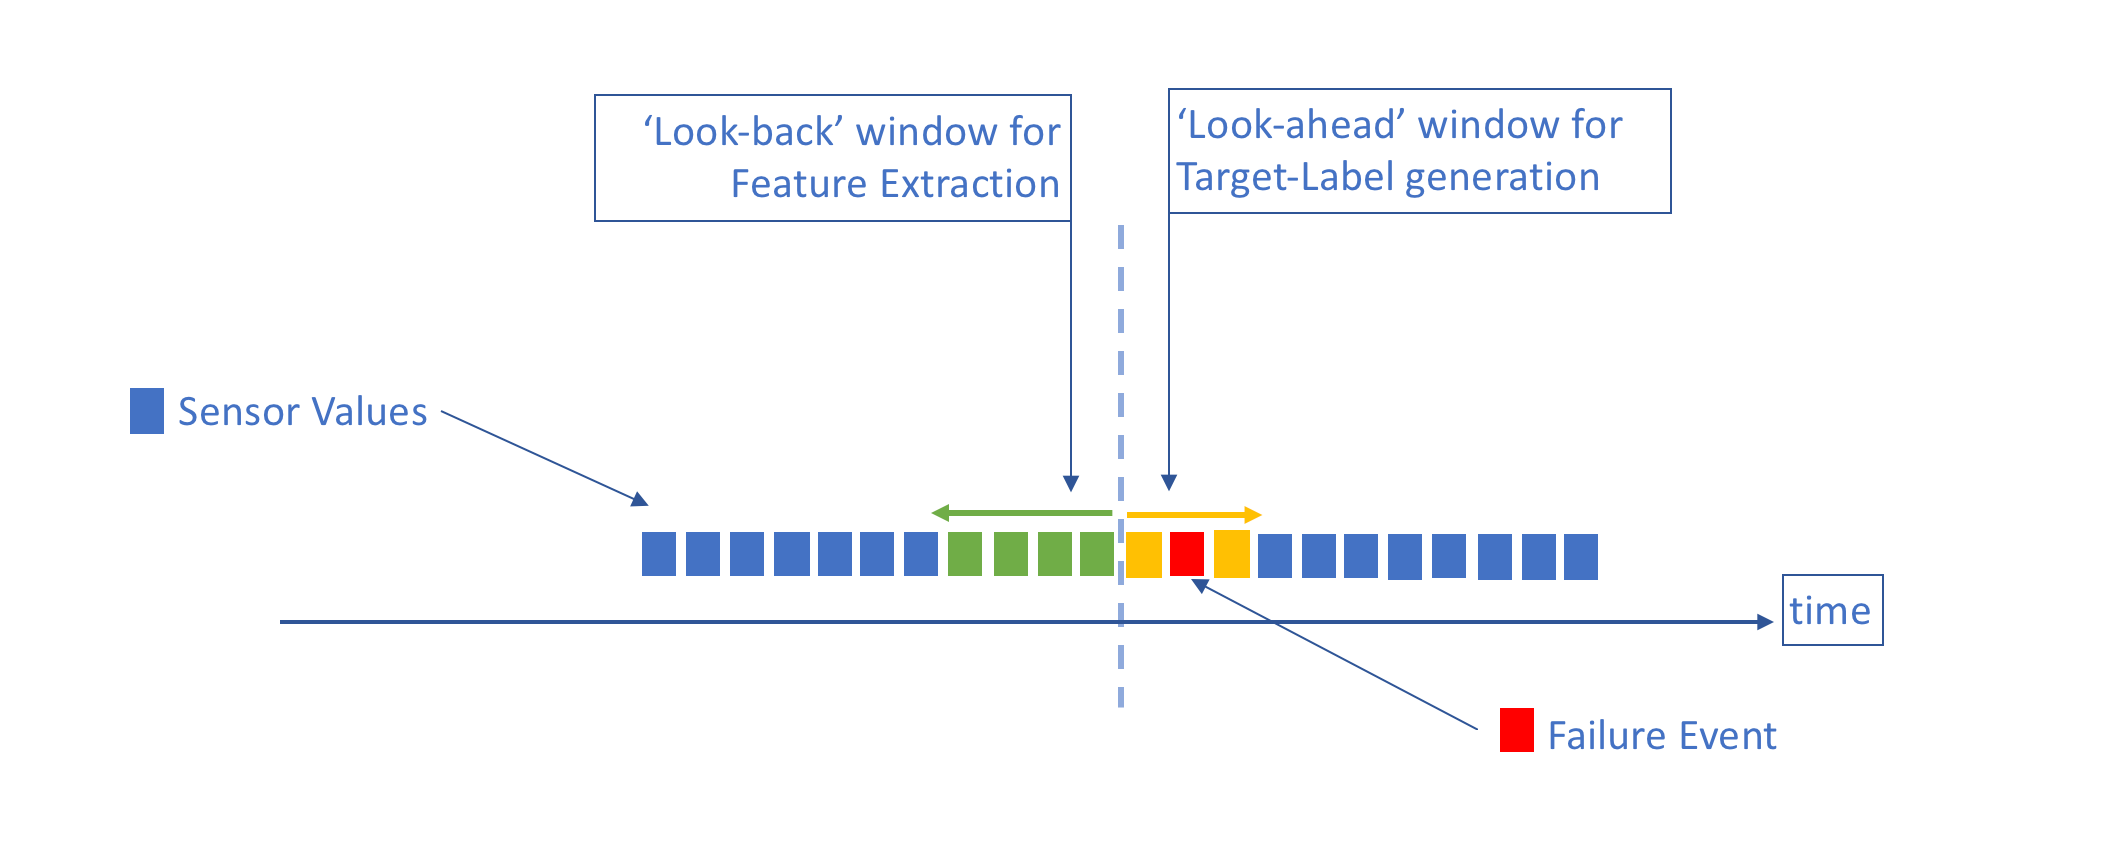

The **workflow** of this notebook is as follows:

* [Data Preparation:](#data_preparation) 
    * The raw data is processed to conform to well-defined schema before using the FPA notebook. The use of a well-defined schema increases the ETL process requirements of users but makes the subsequent processing steps more easily applicable to your data. If you are running this notebook for your own data, you will need to give some thought to how to transform your particular data to the schema defined here.


* [Data Preprocessing:](#preprocessing)
    * The resulting tables from step 1 are then processed to perform feature engineering on and to extract potentially useful modeling features. You will not have to alter this step assuming you can get your raw data into the schema defined. The features we extract are motivated by many years our experience with the types of features that have proven useful in such problem contexts;
    * Features are created from the sensor table by specifying the aggregation methods and rolling window size.
    * The target labels are generated for the future windows which act as ground truth while training the model and valiadating it;
    * We create a final table which is the input for the model.
    
    
* [Model building:](#training)
    * Data-driven models are constructued by using machine learning algorithms.
    * Model accuracy can be assessed by prediction functions.


* [Model Evaluation:](#evaluation)
    * The model performance is evaluated using 3 different kinds of metrics:
        1. Day-to-day failure accuracy - How many failure days have been predicted succesfully.
        1. Well failure accuracy - How many failing wells are predicted successfully. 
        1. Absolute failure accuracy - How many total failures have been predicted successfully. 

In [1]:
# Predict_Envs.json is a data file containing the variables needed to run services and access resources from within notebooks.
#
# It must be populated by the user and instructions are contained within it.

import json
import os
# Opening JSON file
f = open('/project_data/data_asset/Predict_Envs.json',)
data = json.load(f)
f.close()
os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']
# README: Change to true if Health/Predict are deployed on different cluster from this CP4D environment
use_external = True
if use_external:
    import os
    os.environ['USER_PROVIDED_HEALTH_URL'] = data['USER_PROVIDED_HEALTH_URL']
    os.environ['USER_PROVIDED_DB_CONNECTION_STRING'] = data['USER_PROVIDED_DB_CONNECTION_STRING']
    os.environ['USER_PROVIDED_URL'] = data['USER_PROVIDED_URL']

In [2]:
import os
os.environ['TRUST_PREDICT']= os.getenv('APM_API_BASEURL')[8:]

In [3]:
!pip install --trusted-host ${TRUST_PREDICT}  -U ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

     |████████████████████████████████| 189.3 MB 5.8 MB/s eta 0:00:011.9 MB/s eta 0:00:02     |███████████████▊                | 92.8 MB 84.9 MB/s eta 0:00:02     |████████████████████▎           | 120.2 MB 84.9 MB/s eta 0:00:01     |██████████████████████▍         | 132.6 MB 5.8 MB/s eta 0:00:10█████▋        | 139.6 MB 5.8 MB/s eta 0:00:09�████████    | 165.3 MB 5.8 MB/s eta 0:00:05
Processing //tmp/1000690000/pip-req-build-i41zziqo/dslib/srom-1.4.0rc7.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000690000/pip-req-build-i41zziqo/dslib/dqlearn-0.4.2.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000690000/pip-req-build-i41zziqo/dslib/aixclient.zip
  Using cached dill-0.3.2-py3-none-any.whl
  Using cached SQLAlchemy-1.3.24-cp38-cp38-manylinux2010_x86_64.whl (1.3 MB)
  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)
  Using cached lifelines-0.14.6-py3-none-any.whl (218 kB)
  Using cached networkx-2.8.5-py3-none-any.whl (2.0 MB)
  Using cached outlier_utils-0.0.3-py3-n

  Using cached jupyter_console-6.4.4-py3-none-any.whl (22 kB)
  Using cached pyDOE-0.3.8-py3-none-any.whl
  Using cached distributed-2022.7.0-py3-none-any.whl (885 kB)
  Using cached msgpack-1.0.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (322 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
  Using cached distributed-2022.6.1-py3-none-any.whl (882 kB)
  Using cached psutil-5.9.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (284 kB)
  Using cached distributed-2022.6.0-py3-none-any.whl (872 kB)
  Using cached distributed-2022.5.2-py3-none-any.whl (872 kB)
  Using cached distributed-2022.5.1-py3-none-any.whl (871 kB)
  Using cached distributed-2022.5.0-py3-none-any.whl (856 kB)
  Using cached distributed-2022.4.2-py3-none-any.whl (856 kB)
  Using cached distributed-2022.4.1-py3-none-any.whl (855 kB)
  Using cached distributed-2022.4.0-py3-none-any.whl (853 kB)
  Using cached distributed-2022.3.0-py3-none-a

  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)


  Using cached QtPy-2.1.0-py3-none-any.whl (68 kB)
  Created wheel for pmlib: filename=pmlib-8.5.1-py3-none-any.whl size=944214 sha256=994b8d6064cf555702cd7a05ac7d1021df1da54bf9c71526ac27852afcd9afcb
  Stored in directory: /tmp/1000690000/pip-ephem-wheel-cache-6na4p5mi/wheels/c3/a9/e0/25487225d1a5a07405d958ebbb38a4dc9a2fbe684535a06b2d
  Created wheel for aixclient: filename=aixclient-1.2.2-py3-none-any.whl size=5088 sha256=6587f73d8ef02ab70c3686b371725d84fe6c58100adfbac4d177d466587de904
  Stored in directory: /tmp/1000690000/pip-ephem-wheel-cache-6na4p5mi/wheels/02/40/23/80c33006b09c2e253a4feecac3acd4effff843b7338783fdd9
Successfully built pmlib aixclient
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: tabulate
    Foun

In [4]:
import srom
srom_version_tag = 'srom-'+srom.__version__
srom.__version__

'1.4.0rc7'

In [5]:
import dqlearn
dqlearn_version_tag = 'dqlearn-'+dqlearn.__version__
dqlearn.__version__

'0.4.2'

In [6]:
!pip install --upgrade pydot

In [7]:
import tensorflow
tensorflow.__version__

'2.4.4'

In [8]:
# keras needs to be installed if GPU is used with the kernel
from tensorflow import keras
tensorflow.keras.__version__

'2.4.0'

In [9]:
import pkg_resources

dists = [d for d in pkg_resources.working_set]

if not('pyspark' in dists):
    print ("pyspark does not exist. Installing ..." )
    !pip install  pyspark=='3.0.3'
else:
    print ("pyspark already exists. Not installing")

pyspark does not exist. Installing ...
     |████████████████████████████████| 209.1 MB 91 kB/s s eta 0:00:01   |███                             | 19.8 MB 9.4 MB/s eta 0:00:21     |████▌                           | 29.6 MB 9.4 MB/s eta 0:00:20     |█████▋                          | 37.0 MB 9.4 MB/s eta 0:00:19��████████▍                   | 81.2 MB 60.8 MB/s eta 0:00:03     |██████████████████              | 118.2 MB 60.8 MB/s eta 0:00:02     |██████████████████████▉         | 148.9 MB 23.6 MB/s eta 0:00:03�███████████        | 156.9 MB 23.6 MB/s eta 0:00:03
     |████████████████████████████████| 198 kB 72.6 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435971 sha256=63bfba1510224bb341dbe31f635f23e6bf3892ddf1a5eacf44329012522171f0
  Stored in directory: /tmp/1000690000/.cache/pip/wheels/7f/28/02/0373b4f55c817bebc0dfe467728642269180aecfc771cebd06
Successfully built pyspark


In [10]:
import pyspark
pyspark.__version__

'3.0.3'

In [11]:
pip install feature_engine=='1.2.0'

     |████████████████████████████████| 205 kB 12.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


### Importing libraries

Defining important variables and importing required libraries 

In [12]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

from srom.pipeline.srom_pipeline import SROMPipeline
from srom.pipeline.srom_param_grid import SROMParamGrid
from srom.utils.no_op import NoOp
from srom.classification.smart_classification import SmartClassification
#import dqlearn

In [13]:
# All the libraries to be imported are defined here
import os
import json
from io import StringIO
from datetime import datetime

import sys
import types
import ibm_boto3

import matplotlib
import numpy as np
import pandas as pd

import warnings
import json

from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import xgboost


from srom.utils import file_utils, s3utils

import seaborn as sbn

from IPython.display import Markdown
%matplotlib inline

In [14]:
#use the following flags to suppress the pointless pyspark logs that fill up space
import logging
logging.getLogger('pyspark').setLevel(logging.ERROR)
logging.getLogger('py4j').setLevel(logging.ERROR)
logging.getLogger('py4j.java_gateway').setLevel(logging.ERROR)

In [15]:
from project_lib import Project
current_working_ws_project = Project.access()

## Loading the Data 

The Failure Prediction Analysis notebook takes two datasets as input:
* **Sensor Data**:
    * This dataset contains multiple sensor readings for different dates and different assets;
    * Ideally, every asset has a sensor reading for all the dates for the overall time duration of interest;
    * If this is not the case, (i.e., a reading is not present for one or more timestamps), it is treated as a NaN (not a number) and are generally dropped from consideration in the analysis because without a date it becomes impossible to relate these (for modeling purposes) to sensor readings either before or after the failure;
    
    
* **Failure History Data**:
    * This dataset contains the failure data for the differnet assets, the date of the failure, and the failure type denoted by 'failure ID'.
    * The failure ID is generated for every unique failure type that can occur in the asset. 
    * The schema for the Failure Data table is described below:

The schema for the Sensor Data table is shown below:

| asset_id (string)    | timestamp  (UTC recommended)              | variable 1  (float) | variable 2 (float) | variable 3 (float) | variable n (float)
| ------------- |:--------------------------- |:---------------------- |:---------------------- |:--------------------- |:----------------------
| P-0983      | 2006-08-27 19:56:41 | 73.54                    | 22.56                     | 38.54                    | 39.392
| A-3748      | 2006-08-28 11:32:17 | 80.44                    | -26.384                 |  43.965                 | 7.493


And for the failure history data:

| asset_id (string)    | timestamp  (UTC recommended)                | failure_id (integer) 
| ------------- |:--------------------------- |:---------------------- ----------
| P-0983      | 2006-08-27 19:56:41 | 1                    
| A-3748      | 2006-08-28 11:32:17 | 1                    
    
**Note:** 
* For this notebook to function properly, it is mandatory to have the **timestamps** in Sensor data and the Failure data to be over the same range. Similarly, the **assets** in the Failure table should be present in the Sensor data as well (for you database people, it's the same has having the correct foreign key mapping to be used for join operations); 
* The dates in the table should be in UTC format (so that we can avoid timezone complications).

### 1. Loading the Sensor Data

In the data below, we have multiple assets for which we want to perform failure analysis. We also have a range of dates over which we are observing these assets. For each asset, we record the sensor readings during the date range. (in this examples, we have 3 sensor associated with each asset: sensor_1, sensor_2, and sensor_3). For each asset, we are recording the sensor values for all the dates lying in the range of dates. 


The Sensor data is imported into the notebook from a CSV file. The CSV files for this notebook are in the subfolder 'dataset'. Once the dataset is imported, the asset_id column name is specified in the variable 'sensor_asset_id_column_name' and the date column name is specified in the variable 'sensor_date_column_name'. Finally, the format of the date needs to specified using [python's datetime format.](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

###### Define some meta data and load the sensor data

In [16]:
sensor_asset_id_column_name = 'asset_id'                  
sensor_date_column_name = 'timestamp'              
sensor_date_format = '%Y-%m-%d %H:%M:%S'  

In [18]:
#sensor_data_full_df = pd.read_csv('/project_data/data_asset/kaggle_pump_reindexed_v2.csv')
sensor_data_full_df = pd.read_csv('/project_data/data_asset/kaggle_pump_resampled_reindexed.csv')
#print(sensor_data_df.columns.tolist())
if 'Unnamed: 0' in sensor_data_full_df.columns.tolist():
    sensor_data_full_df.drop('Unnamed: 0', axis = 1, inplace = True)
if 'index' in sensor_data_full_df.columns.tolist():
    sensor_data_full_df.drop('index', axis = 1, inplace = True)
sensor_data_full_df[sensor_asset_id_column_name] = 'pump-123'
sensor_data_full_df = sensor_data_full_df.drop_duplicates(subset=[sensor_asset_id_column_name, sensor_date_column_name])
sensor_data_full_df[sensor_date_column_name] = pd.to_datetime(sensor_data_full_df[sensor_date_column_name], format=sensor_date_format)
print('Machine Status values = ', sensor_data_full_df['machine_status'].value_counts())
print(sensor_data_full_df.shape)
print(sensor_data_full_df.isna().sum())
display(sensor_data_full_df.head())
sensor_data_full_df.tail()

Machine Status values =  NORMAL        1138
RECOVERING      79
BROKEN           7
Name: machine_status, dtype: int64
(1224, 55)
timestamp            0
sensor_00           52
sensor_01            0
sensor_02            0
sensor_03            0
sensor_04            0
sensor_05            0
sensor_06           23
sensor_07           27
sensor_08           25
sensor_09           22
sensor_10            0
sensor_11            0
sensor_12            0
sensor_13            0
sensor_14            0
sensor_15         1224
sensor_16            0
sensor_17            0
sensor_18            0
sensor_19            0
sensor_20            0
sensor_21            0
sensor_22            0
sensor_23            0
sensor_24            0
sensor_25            0
sensor_26            0
sensor_27            0
sensor_28            0
sensor_29            0
sensor_30            0
sensor_31            0
sensor_32            0
sensor_33            0
sensor_34            0
sensor_35            0
sensor_36            

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
0 2019-11-25   2.454124  48.521651  53.086659  45.917967  634.261195   
1 2019-11-26   2.454091  48.067611  52.885319  45.239437  634.028005   
2 2019-11-27   2.454162  46.882473  52.547741  44.823735  633.935177   
3 2019-11-28   2.454222  46.601319  52.434171  45.273677  634.954348   
4 2019-11-29   2.453987  47.860242  52.780427  46.145350  634.696986   

   sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_44  sensor_45  \
0  75.106401  13.517834  16.159856  15.694364  ...  41.407857  49.429334   
1  72.457242  13.597486  16.157967  15.696575  ...  53.991448  61.837706   
2  74.061776  13.513292  16.160580  15.666554  ...  55.351402  55.592528   
3  73.439419  13.344946  16.167010  15.678169  ...  54.710005  50.724987   
4  75.166017  13.351055  16.161303  15.673628  ...  59.770448  52.858153   

   sensor_46  sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  \
0  46.482768  39.031957  183.920076   75.800541  231.928371  207.921807   
1  51.240998  38.736175  200.657471  103.338798  245.225696  216.391781   
2  42.742091  39.072144  214.248972  108.018260  241.538062  210.863552   
3  44.700038  42.306456  200.869662   96.164481  242.978392  212.594844   
4  48.866705  42.751736  202.019033  101.538388  231.573112  220.992476   

   asset_id  machine_status  
0  pump-123          NORMAL  
1  pump-123          NORMAL  
2  pump-123          NORMAL  
3  pump-123          NORMAL  
4  pump-123          NORMAL  

[5 rows x 55 columns]

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
1219 2023-03-28   2.402791  51.593362  51.257954  44.655670  627.556543   
1220 2023-03-29   2.420822  50.335646  52.329763  45.108264  630.655406   
1221 2023-03-30   2.402808  50.565199  52.166761  44.605274  632.023558   
1222 2023-03-31   2.402592  49.398244  51.008070  43.506011  631.933956   
1223 2023-04-01   2.402649  47.933544  50.588349  43.128857  631.943893   

      sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_44  sensor_45  \
1219  77.754073  14.987380  16.526290  15.708309  ...  76.284401  65.266525   
1220  73.575111  15.106818  16.932628  15.960086  ...  88.118893  71.498842   
1221  75.681375  15.112043  17.167246  16.185417  ...  71.024626  66.642554   
1222  72.777791  15.116304  16.803865  15.803025  ...  67.585726  55.720666   
1223  70.282040  15.110556  16.658832  15.674793  ...  62.618955  56.540959   

      sensor_46  sensor_47   sensor_48   sensor_49  sensor_50   sensor_51  \
1219  59.722222  44.047389  279.935054  131.312694        NaN  234.799381   
1220  65.043081  50.483861  315.470678  168.688913        NaN  245.492544   
1221  57.101980  45.534336  241.833846   99.614199        NaN  192.677789   
1222  54.664613  41.153353  260.241748  115.474271        NaN  220.535154   
1223  55.135995  44.523211  287.753986  115.928823        NaN  219.936341   

      asset_id  machine_status  
1219  pump-123          NORMAL  
1220  pump-123          NORMAL  
1221  pump-123          NORMAL  
1222  pump-123          NORMAL  
1223  pump-123          NORMAL  

[5 rows x 55 columns]

In [19]:
sensor_data_full_df[sensor_data_full_df['machine_status'] == 'BROKEN'].head(15)

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
95  2020-02-28   0.000000  53.342010  52.821180  43.402775  202.526031   
136 2020-04-09   1.093982  42.534720  47.699650  41.449650  206.038757   
385 2020-12-14   2.258796  47.265630  52.734370  43.446178  200.115738   
432 2021-01-30   2.321759  47.482640  51.475693  42.795135  612.152800   
711 2021-11-05   0.364005  40.190970  45.225690  40.190971  201.368622   
784 2022-01-17   0.001968  45.138890  52.907990  45.355900  500.000000   
924 2022-06-06   2.318808  45.833332  52.994790  43.880210  420.503448   

     sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_44  sensor_45  \
95    49.79289   3.219039  16.890910  16.869210  ...   50.92593  51.215280   
136   60.30106  12.304690  15.154800  14.185470  ...   34.72222  31.539350   
385   66.14643  13.592300  15.914350  15.147570  ...   35.01157  37.905090   
432   67.30158  14.062500  16.608800  15.943290  ...   65.68287  57.870370   
711    0.00000  11.335360  15.270540  15.183740  ...   28.06713  28.067129   
784    1.40131   0.028935   0.036169   0.036169  ...   37.32639  35.300930   
924   72.52040  14.185470  16.247110  15.697340  ...   52.10200  52.662040   

      sensor_46   sensor_47   sensor_48   sensor_49   sensor_50  sensor_51  \
95    50.636570   46.006940  409.143500  121.527800  401.909700   324.6528   
136   34.432870   33.275460   59.895830   44.560180  177.662000   183.7384   
385   39.062500   45.428240  144.675900   49.768520  246.238400   257.5231   
432  127.893500  153.935200  155.381900   65.682870  220.196800   267.3611   
711   29.513889   29.224537   29.224537   29.513889   32.407406        NaN   
784   38.194440   43.402780   99.537030   44.849540  192.129600   174.7685   
924   67.129630   43.981480  230.324100   69.733800         NaN   205.7292   

     asset_id  machine_status  
95   pump-123          BROKEN  
136  pump-123          BROKEN  
385  pump-123          BROKEN  
432  pump-123          BROKEN  
711  pump-123          BROKEN  
784  pump-123          BROKEN  
924  pump-123          BROKEN  

[7 rows x 55 columns]

In [20]:
# From the output above, it is clear that sensor_15 is missing values in all rows. So let us remove that variable
print('Shape of the data frame BEFORE dropping sensor_15 = ', sensor_data_full_df.shape)
sensor_data_full_df.drop('sensor_15', axis = 1, inplace = True)
print('Shape of the data frame AFTER dropping sensor_15 = ', sensor_data_full_df.shape)

Shape of the data frame BEFORE dropping sensor_15 =  (1224, 55)
Shape of the data frame AFTER dropping sensor_15 =  (1224, 54)


As can be seen in the previous output, the data is highly imbalanced. Only 7 broken outcomes against 205836 normal outcomes.  Let us see how the recovery phases are distributed against the normal and broken situations

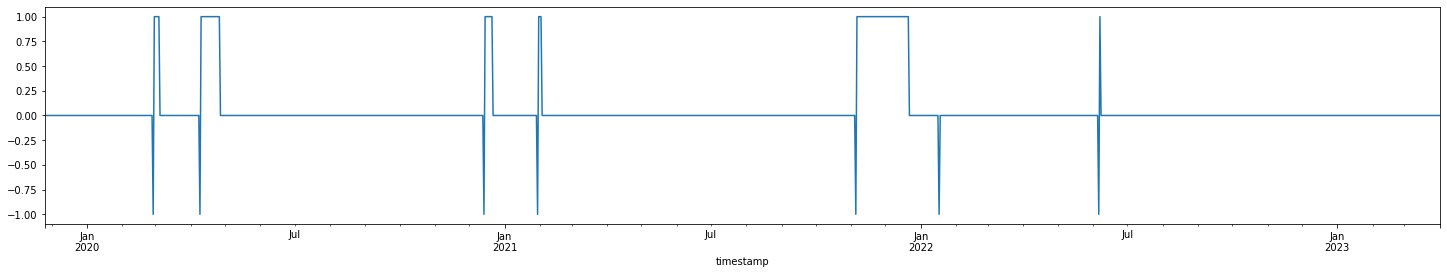

In [21]:
sensor_data_ts_plot_df = sensor_data_full_df.set_index(sensor_date_column_name)
sensor_data_ts_plot_df['machine_condition'] = sensor_data_ts_plot_df['machine_status'].map(lambda x: 0 if x == 'NORMAL' else 1 if x =='RECOVERING' else -1)
sensor_data_ts_plot_df['machine_condition'].plot(figsize = (25, 4))

Redraw a clearer plot for a smaller window of time. We can see the recovery phase is recorded right after the broken state was observed (without any downtime, which is a bit strange).

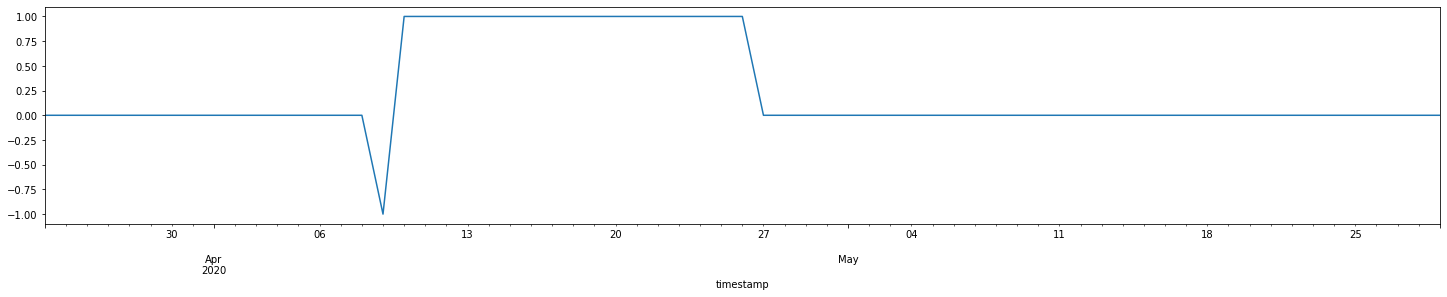

In [22]:
sensor_data_ts_plot_df[(sensor_data_ts_plot_df.index > pd.to_datetime('2020-03-23')) & (sensor_data_ts_plot_df.index < pd.to_datetime('2020-05-30'))]['machine_condition'].plot(figsize = (25, 4))

In [23]:
sensor_data_ts_plot_df[(sensor_data_ts_plot_df.index > pd.to_datetime('2020-03-23')) & (sensor_data_ts_plot_df.index < pd.to_datetime('2020-04-03'))]['machine_status'].head(10)

timestamp
2020-03-24    NORMAL
2020-03-25    NORMAL
2020-03-26    NORMAL
2020-03-27    NORMAL
2020-03-28    NORMAL
2020-03-29    NORMAL
2020-03-30    NORMAL
2020-03-31    NORMAL
2020-04-01    NORMAL
2020-04-02    NORMAL
Name: machine_status, dtype: object

It is clear from the above plots that recovery phase starts immediately after a failure (broken state) and lasts for different duration.

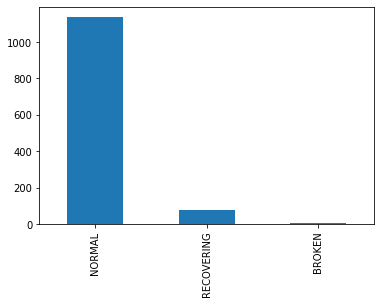

In [24]:
sensor_data_full_df['machine_status'].value_counts().plot(kind = 'bar')

The data is highly imbalanced. There are very few failures indicated as 'BROKEN' condition, followed by different durations of recovery phase. There are a few ways to handle this scenario

1. Trim the NORMAL phase by discarding early values. The assumption here is the onset of failure is very close to the point of failure, and therefore a small subset of normal data followed by failure data is sufficient to model
2. Treat RECOVERING phase as downtime along with BROKEN phase. This would mean treating BROKEN and RECOVERING as a continuous phase, indicating one occurrence of failure.
3. Combination of #1 and #2
4. Drop RECOVERY records and early set of NORMAL records

In [25]:
sensor_data_full_df['target_label'] = sensor_data_full_df['machine_status'].map(lambda x: 0 if x == 'NORMAL' else 1)

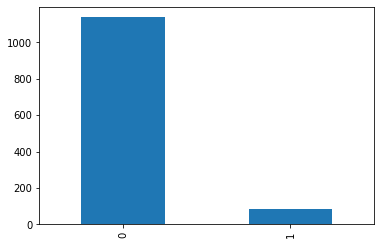

In [26]:
sensor_data_full_df['target_label'].value_counts().plot(kind = 'bar')

In [27]:
sensor_measurements = sorted(list(set(sensor_data_full_df.columns.tolist()) - set(['machine_status', 'target_label', sensor_asset_id_column_name, sensor_date_column_name])))
print(sensor_measurements)

['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51']


##### Test the sensitvity of the variables to machine condition. This is one simple / straight forward way of selecting features


In [28]:
## To adjust for the scale normalize the data before plotting
from sklearn.preprocessing import MinMaxScaler
normalized_sensor_data = MinMaxScaler().fit_transform(sensor_data_full_df[sensor_measurements])
normalized_sensor_data_df = pd.DataFrame(normalized_sensor_data, columns = sensor_measurements)
print(normalized_sensor_data_df.shape)
display(normalized_sensor_data_df.head())
normalized_sensor_data_df.tail()

(1224, 51)


sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
0   0.966539   0.724971   0.878787   0.873853   0.984467   0.751065   
1   0.966526   0.704724   0.869896   0.831507   0.984103   0.724573   
2   0.966554   0.651875   0.854989   0.805565   0.983958   0.740619   
3   0.966577   0.639337   0.849974   0.833644   0.985548   0.734395   
4   0.966485   0.695476   0.865264   0.888043   0.985146   0.751661   

   sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_42  sensor_43  \
0   0.890268   0.783269   0.739595   0.699290  ...   0.039612   0.053493   
1   0.895523   0.783178   0.739700   0.699396  ...   0.034725   0.049732   
2   0.889969   0.783304   0.738282   0.699144  ...   0.034641   0.048494   
3   0.878863   0.783617   0.738831   0.699100  ...   0.046328   0.063443   
4   0.879266   0.783340   0.738616   0.699353  ...   0.057299   0.071748   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0   0.204305   0.259944   0.117560   0.091753   0.411646   0.156634   
1   0.369267   0.400015   0.145387   0.089415   0.455370   0.244352   
2   0.387095   0.329517   0.095684   0.092071   0.490875   0.259258   
3   0.378686   0.274570   0.107134   0.117637   0.455924   0.221500   
4   0.445025   0.298650   0.131502   0.121156   0.458927   0.238617   

   sensor_50  sensor_51  
0   0.209998   0.185159  
1   0.223675   0.193872  
2   0.219882   0.188185  
3   0.221363   0.189966  
4   0.209632   0.198605  

[5 rows x 51 columns]

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
1219   0.946322   0.861948   0.798034   0.795076   0.974009   0.777542   
1220   0.953423   0.805862   0.845363   0.823321   0.978843   0.735752   
1221   0.946328   0.816099   0.838166   0.791931   0.980977   0.756815   
1222   0.946243   0.764061   0.787000   0.723329   0.980837   0.727779   
1223   0.946266   0.698745   0.768466   0.699792   0.980852   0.702821   

      sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_42  sensor_43  \
1219   0.987213   0.801065   0.740254   0.700745  ...   0.050818   0.064353   
1220   0.995093   0.820798   0.752141   0.711544  ...   0.052993   0.069868   
1221   0.995437   0.832192   0.762779   0.711818  ...   0.057617   0.061711   
1222   0.995718   0.814545   0.744725   0.702741  ...   0.034201   0.054591   
1223   0.995339   0.807502   0.738671   0.699452  ...   0.030497   0.059880   

      sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
1219   0.661511   0.438720   0.194987   0.131398   0.662467   0.333458   
1220   0.816652   0.509073   0.226104   0.182274   0.755297   0.452513   
1221   0.592559   0.454253   0.179663   0.143151   0.562935   0.232488   
1222   0.547478   0.330963   0.165409   0.108522   0.611022   0.283008   
1223   0.482367   0.340223   0.168166   0.135159   0.682893   0.284455   

      sensor_50  sensor_51  
1219        NaN   0.212809  
1220        NaN   0.223809  
1221        NaN   0.169477  
1222        NaN   0.198135  
1223        NaN   0.197519  

[5 rows x 51 columns]

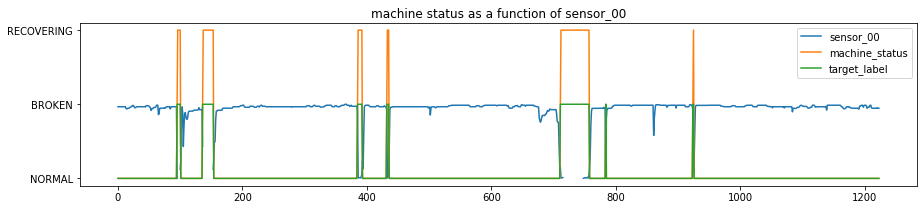

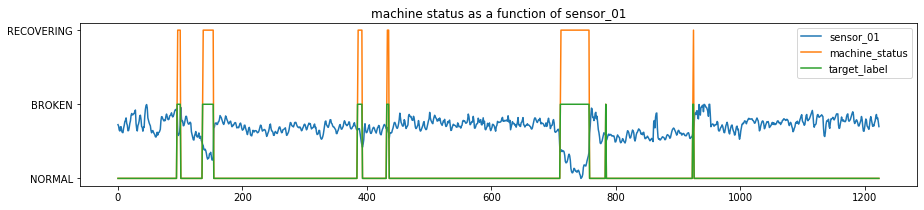

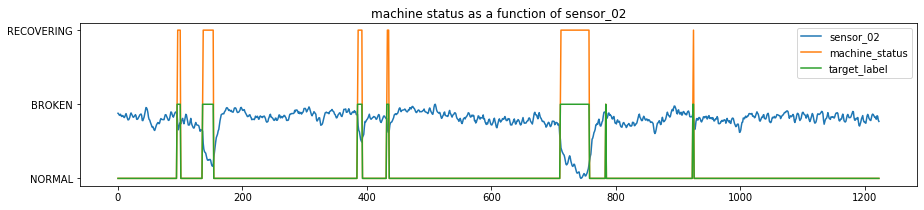

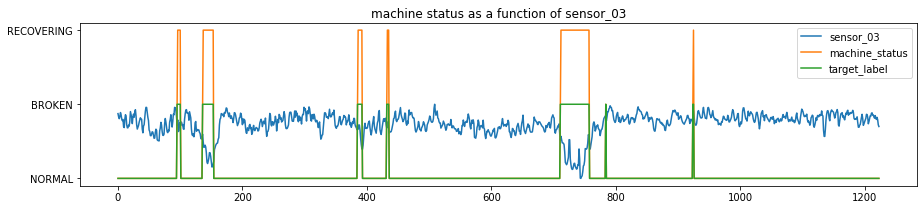

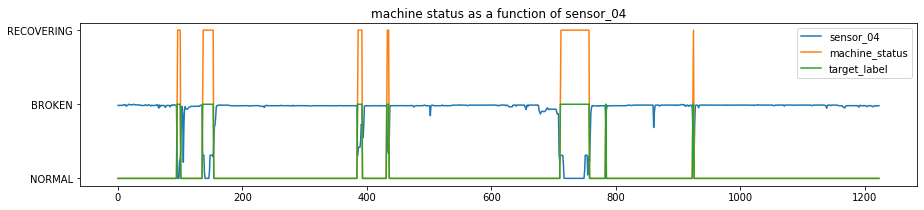

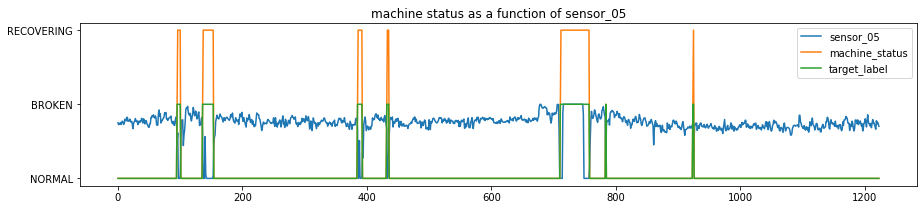

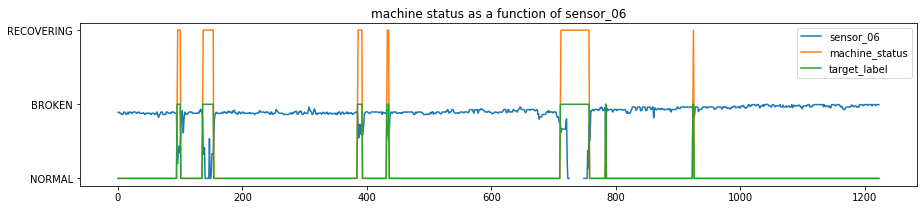

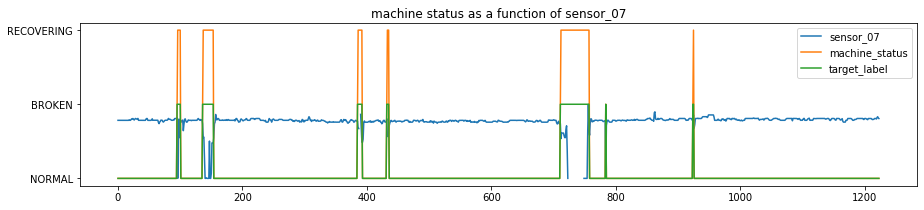

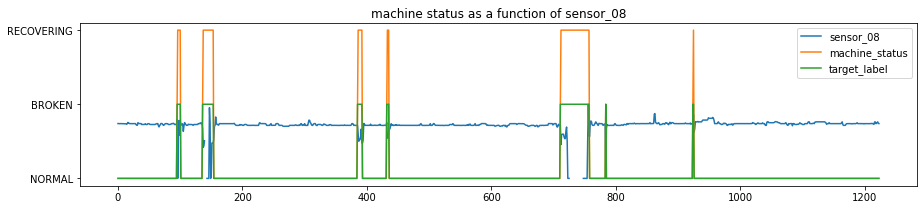

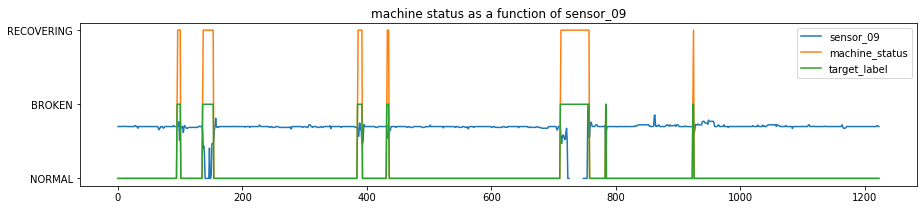

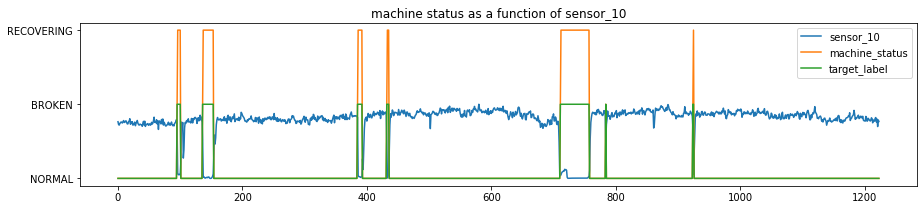

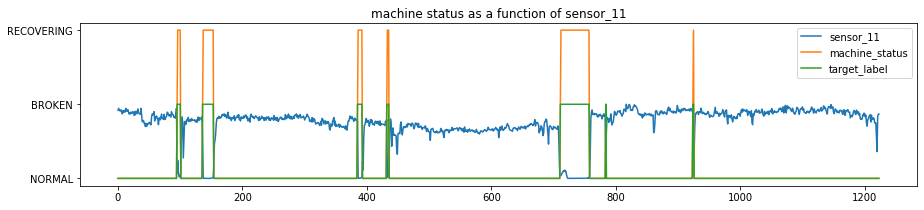

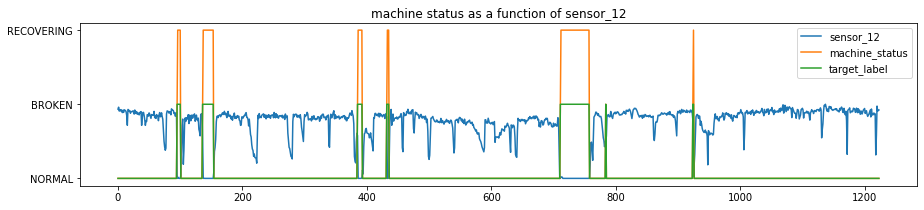

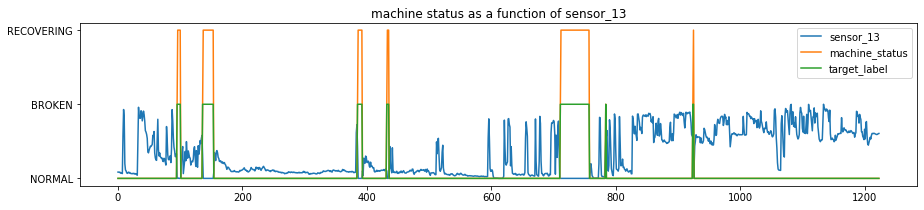

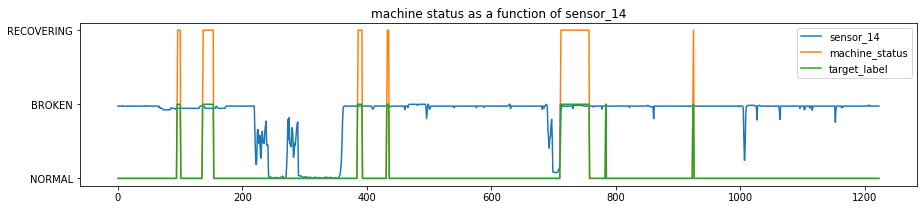

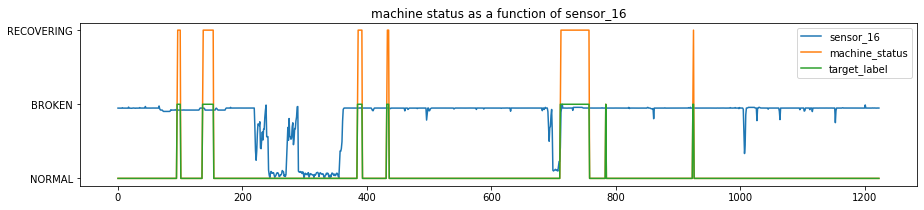

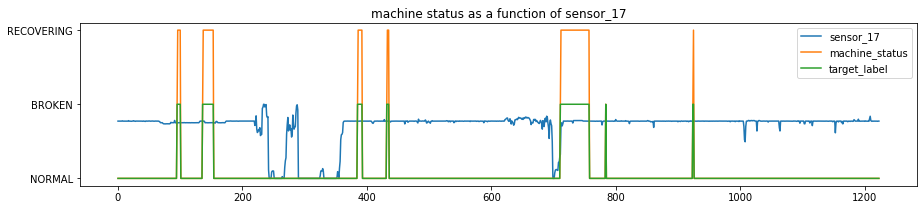

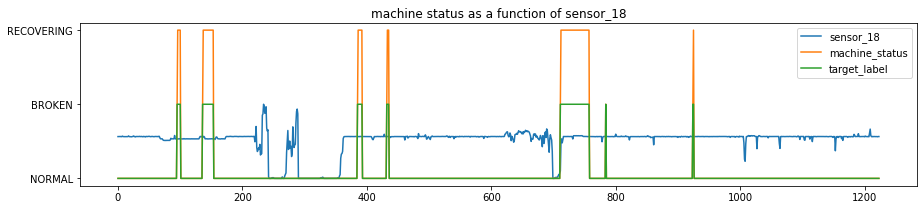

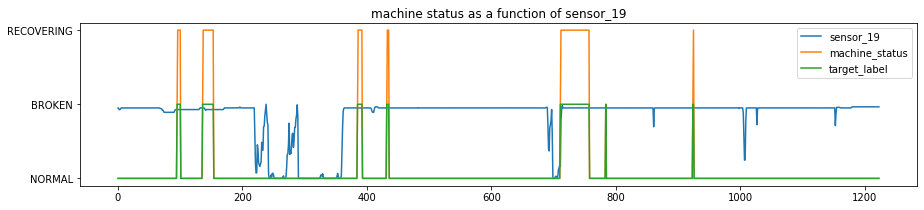

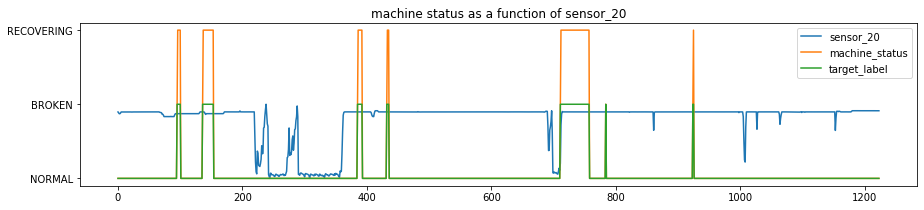

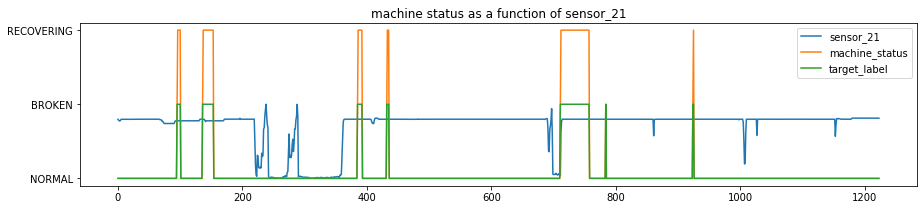

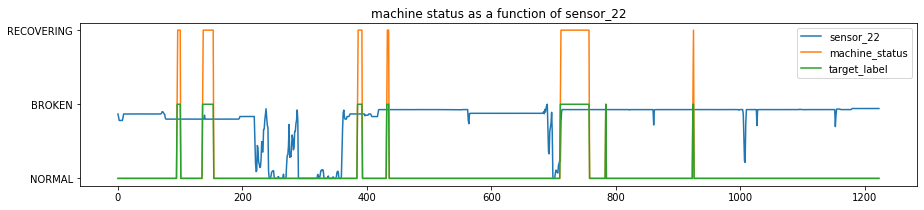

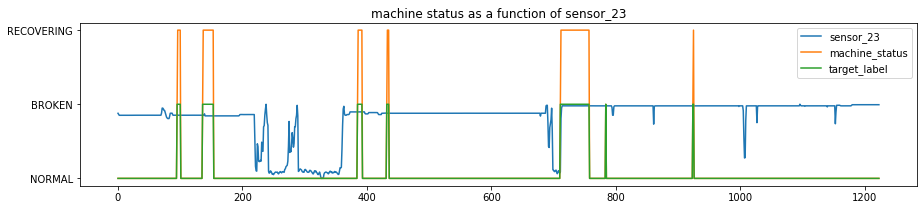

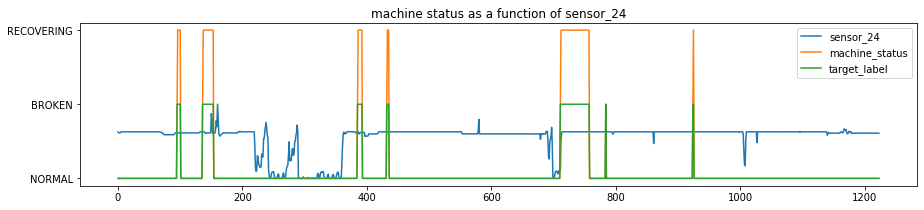

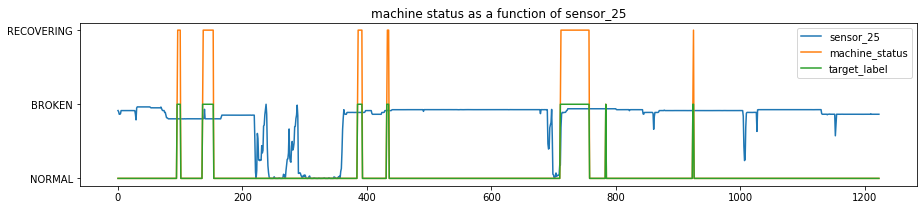

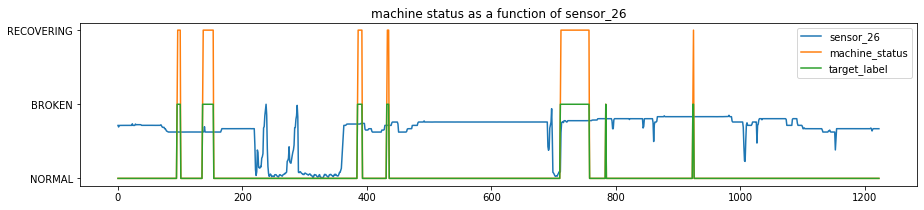

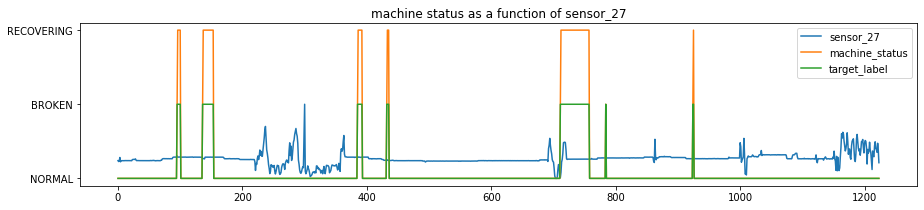

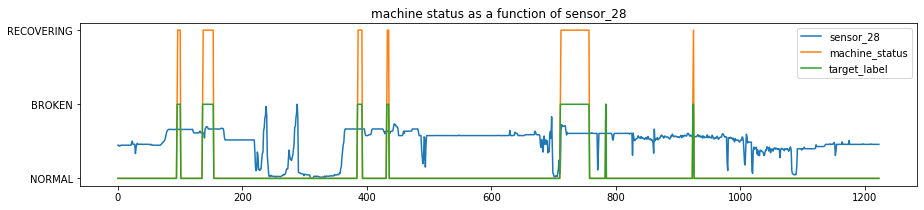

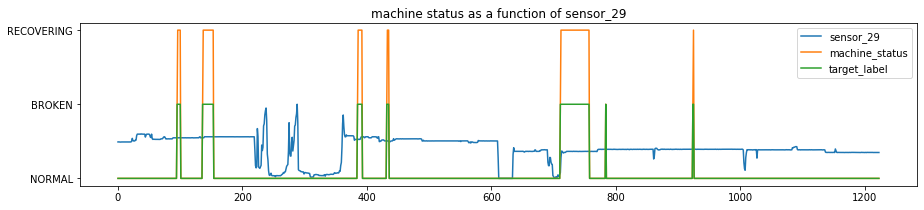

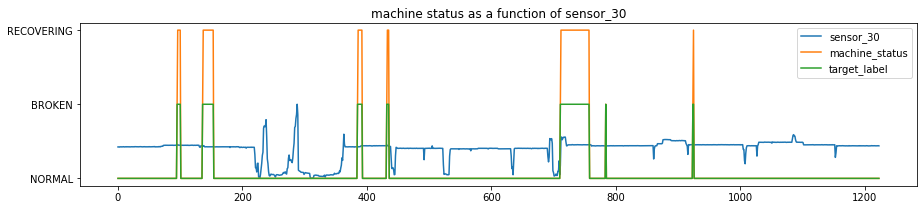

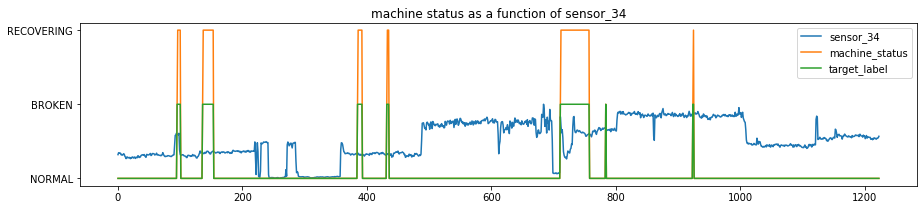

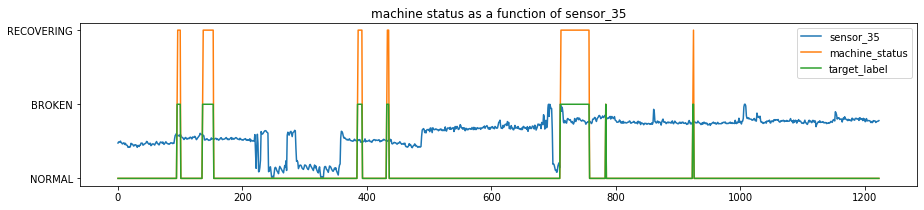

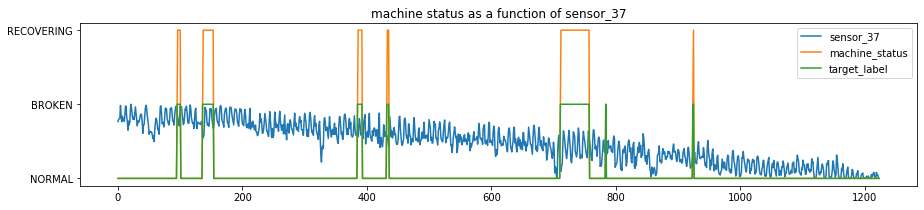

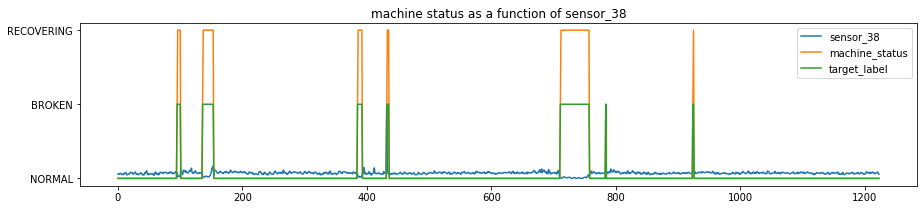

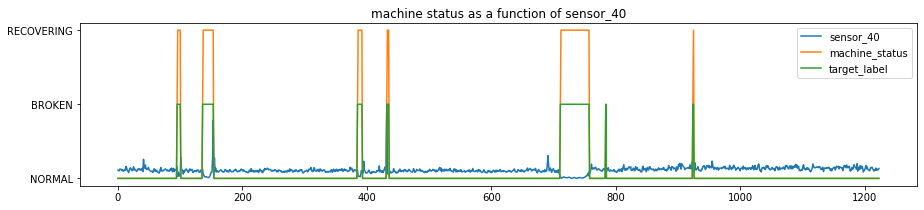

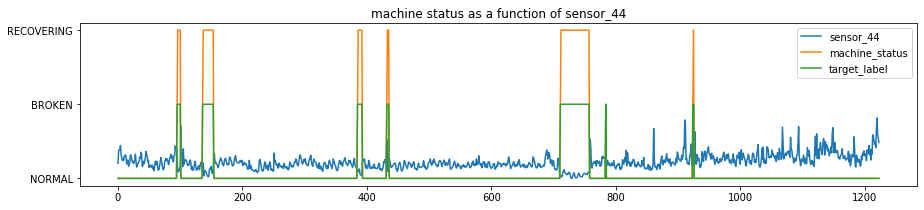

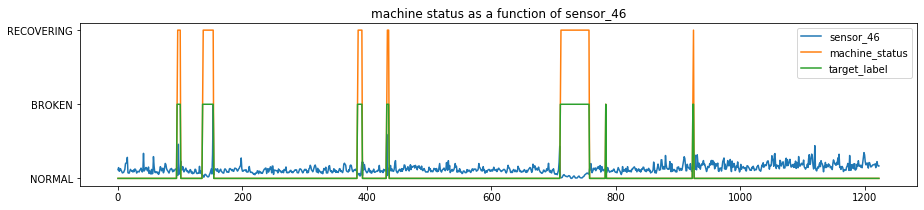

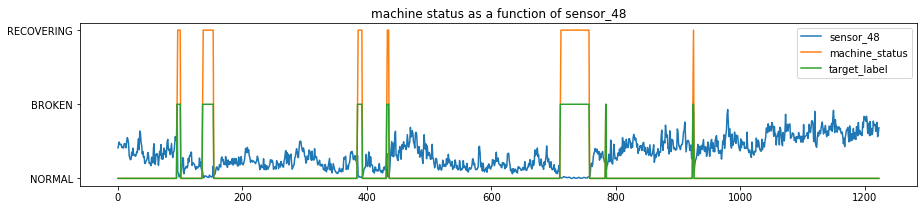

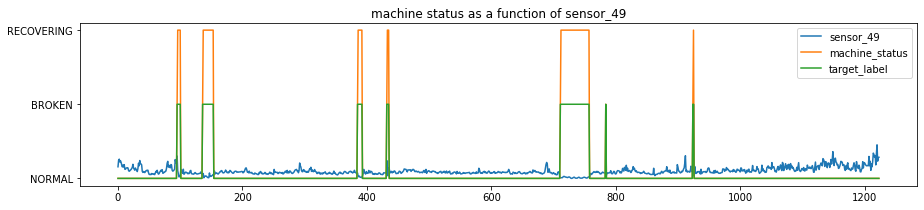

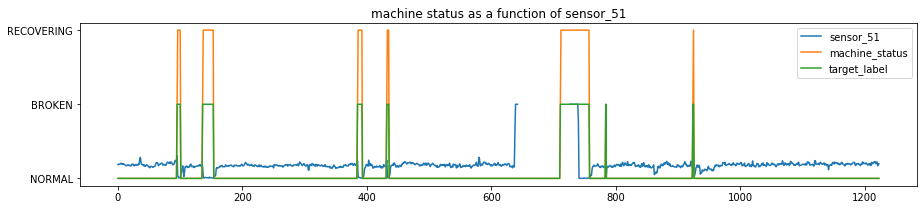

In [29]:
for col in sensor_measurements:
    plt.figure(figsize = (15,3))
    plt.plot(normalized_sensor_data_df[col], label = col)
    plt.plot(sensor_data_full_df['machine_status'], label = 'machine_status')
    plt.plot(sensor_data_full_df['target_label'], label = 'target_label')
    plt.title('machine status as a function of '+col)
    plt.legend()
    plt.show()
plt.close()

In [30]:
sensor_data_correlations_df = sensor_data_full_df[sensor_measurements].corr()
plt.figure(figsize = (27, 27))
sbn.heatmap(sensor_data_correlations_df, annot = True, cmap="tab20c")

In [31]:
from dqlearn.missing.missing_pattern_plot import missing_pattern_plots
from dqlearn.missing.missing_pattern import check_missing_properties

missing_threshold_dict = {}
missing_threshold_dict = {var:0.002 for var in sensor_measurements}

sensor_report = check_missing_properties(df=sensor_data_full_df, data_cols=sensor_measurements, missing_threshold_dict=missing_threshold_dict, default_missing_threshold=0.005,
                                         verify_df=True)
#print(sensor_report()['results']['explanation'])
#print(sensor_report()['results']['details']['feature_missing_properties'])
#print(sensor_report()['results']['explanation'])

sensor_report_dict = sensor_report()
sensor_report_json = json.dumps(sensor_report_dict, indent=4)

print(sensor_report_json)

sensor_list_dict = sensor_report_dict['results']['details']['feature_missing_properties']
sensor_missing_properties_df = pd.DataFrame(sensor_list_dict)
sensor_missing_properties_df = sensor_missing_properties_df.transpose()
#sensor_missing_properties_df = sensor_missing_properties_df[missing_properties].transpose()
pd.set_option("display.max_colwidth", -1)  # Ensure all the contents diaplayed
sensor_missing_properties_df.head(sensor_missing_properties_df.shape[0])

missing_gap_dict OrderedDict([(1, 49), (38, 1), (564, 1)])


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


missing_gap_dict OrderedDict([(1, 25), (335, 1)])
missing_gap_dict OrderedDict([(1, 23), (584, 1)])


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


{
    "results": {
        "title": "Check the missing value properties for features",
        "score": null,
        "explanation": "There are(is) 7 out of 51 features(s) have/has missing value(s)!\nThere are(is) 7 out of 51 features(s) have/has missing ratio(s) higher than the threshold(s)!",
        "recommendations": null,
        "details": {
            "feature_list": [
                "sensor_00",
                "sensor_01",
                "sensor_02",
                "sensor_03",
                "sensor_04",
                "sensor_05",
                "sensor_06",
                "sensor_07",
                "sensor_08",
                "sensor_09",
                "sensor_10",
                "sensor_11",
                "sensor_12",
                "sensor_13",
                "sensor_14",
                "sensor_16",
                "sensor_17",
                "sensor_18",
                "sensor_19",
                "sensor_20",
                "sensor_21",
           

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-31-01a49d54bba1>:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)  # Ensure all the contents diaplayed


sample_size num_missing contain_missing missing_rate  \
sensor_00  1224        52          True            0.042         
sensor_01  1224        0           False           0.0           
sensor_02  1224        0           False           0.0           
sensor_03  1224        0           False           0.0           
sensor_04  1224        0           False           0.0           
sensor_05  1224        0           False           0.0           
sensor_06  1224        23          True            0.019         
sensor_07  1224        27          True            0.022         
sensor_08  1224        25          True            0.02          
sensor_09  1224        22          True            0.018         
sensor_10  1224        0           False           0.0           
sensor_11  1224        0           False           0.0           
sensor_12  1224        0           False           0.0           
sensor_13  1224        0           False           0.0           
sensor_14  1224        0           False           0.0           
sensor_16  1224        0           False           0.0           
sensor_17  1224        0           False           0.0           
sensor_18  1224        0           False           0.0           
sensor_19  1224        0           False           0.0           
sensor_20  1224        0           False           0.0           
sensor_21  1224        0           False           0.0           
sensor_22  1224        0           False           0.0           
sensor_23  1224        0           False           0.0           
sensor_24  1224        0           False           0.0           
sensor_25  1224        0           False           0.0           
sensor_26  1224        0           False           0.0           
sensor_27  1224        0           False           0.0           
sensor_28  1224        0           False           0.0           
sensor_29  1224        0           False           0.0           
sensor_30  1224        0           False           0.0           
sensor_31  1224        0           False           0.0           
sensor_32  1224        0           False           0.0           
sensor_33  1224        0           False           0.0           
sensor_34  1224        0           False           0.0           
sensor_35  1224        0           False           0.0           
sensor_36  1224        0           False           0.0           
sensor_37  1224        0           False           0.0           
sensor_38  1224        0           False           0.0           
sensor_39  1224        0           False           0.0           
sensor_40  1224        0           False           0.0           
sensor_41  1224        0           False           0.0           
sensor_42  1224        0           False           0.0           
sensor_43  1224        0           False           0.0           
sensor_44  1224        0           False           0.0           
sensor_45  1224        0           False           0.0           
sensor_46  1224        0           False           0.0           
sensor_47  1224        0           False           0.0           
sensor_48  1224        0           False           0.0           
sensor_49  1224        0           False           0.0           
sensor_50  1224        427         True            0.349         
sensor_51  1224        84          True            0.069         

          missing_rate_lower_threshold missing_rate_threshold  \
sensor_00  False                        0.002                   
sensor_01  True                         0.002                   
sensor_02  True                         0.002                   
sensor_03  True                         0.002                   
sensor_04  True                         0.002                   
sensor_05  True                         0.002                   
sensor_06  False                        0.002                   
sensor_07  False                        0.002            

In [33]:
from srom.auto.auto_imputation import AutoImputation

scoring_strategy = "neg_mean_absolute_error"  # any sklearn defined regression metric is fine

# possible values include ImputationKFold, MARImputationKFold, and MNARImputationKFold, ImputationKFold, 
# Other two candidate kfold types for time series are: a) TsIIDConsecutiveKFold, b) TsVariableConsecutiveKFold
cv_type = "ImputationKFold"
imputation_type = "timeseries" # either iid or timeseries
cv = 5
total_execution_time = 10

sensor_data_imputation_ts = AutoImputation(
    level='default', 
    save_prefix='auto_imputation_timeseries', 
    execution_platform='spark_node_random_search', 
    cv_type=cv_type,  
    cv=cv,
    scoring=scoring_strategy, 
    stages=None, 
    execution_time_per_pipeline=2, 
    num_options_per_pipeline_for_random_search=10,
    num_option_per_pipeline_for_intelligent_search=30, 
    total_execution_time=total_execution_time, 
    param_grid=None, 
    missing_vals=0.1, 
    random_state=42,
    imputation_type=imputation_type)


sensor_X = sensor_data_full_df[sensor_measurements].values

%time sensor_data_imputation_ts.automate(sensor_X, sensor_X)

sensor_data_imputation_ts.fit(sensor_X, sensor_X)
sensor_data_imputed_ts = sensor_data_imputation_ts.transform(sensor_X)

sensor_data_full_imputed_df = pd.DataFrame(sensor_data_imputed_ts, columns=sensor_measurements)
sensor_data_full_imputed_df[[sensor_asset_id_column_name, sensor_date_column_name,'machine_status']] = sensor_data_full_df[[sensor_asset_id_column_name, sensor_date_column_name,'machine_status']]
print(sensor_data_full_imputed_df.isna().sum())
sensor_data_full_imputed_df[[sensor_asset_id_column_name, sensor_date_column_name, 'target_label', 'machine_status']] = \
sensor_data_full_df[[sensor_asset_id_column_name, sensor_date_column_name, 'target_label', 'machine_status']]
sensor_data_full_imputed_df = sensor_data_full_imputed_df[[sensor_asset_id_column_name, sensor_date_column_name]+sensor_measurements+['machine_status','target_label']]
sensor_data_full_imputed_df.head()

None of the grid parameters matched for the given stages.
None of the grid parameters matched for the given stages.


CPU times: user 147 ms, sys: 25 ms, total: 172 ms
Wall time: 25.5 s
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47   

asset_id  timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  pump-123 2019-11-25  2.454124   48.521651  53.086659  45.917967   
1  pump-123 2019-11-26  2.454091   48.067611  52.885319  45.239437   
2  pump-123 2019-11-27  2.454162   46.882473  52.547741  44.823735   
3  pump-123 2019-11-28  2.454222   46.601319  52.434171  45.273677   
4  pump-123 2019-11-29  2.453987   47.860242  52.780427  46.145350   

    sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_44  sensor_45  \
0  634.261195  75.106401  13.517834  16.159856  ...  41.407857  49.429334   
1  634.028005  72.457242  13.597486  16.157967  ...  53.991448  61.837706   
2  633.935177  74.061776  13.513292  16.160580  ...  55.351402  55.592528   
3  634.954348  73.439419  13.344946  16.167010  ...  54.710005  50.724987   
4  634.696986  75.166017  13.351055  16.161303  ...  59.770448  52.858153   

   sensor_46  sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  \
0  46.482768  39.031957  183.920076  75.800541   231.928371  207.921807   
1  51.240998  38.736175  200.657471  103.338798  245.225696  216.391781   
2  42.742091  39.072144  214.248972  108.018260  241.538062  210.863552   
3  44.700038  42.306456  200.869662  96.164481   242.978392  212.594844   
4  48.866705  42.751736  202.019033  101.538388  231.573112  220.992476   

   machine_status  target_label  
0  NORMAL          0             
1  NORMAL          0             
2  NORMAL          0             
3  NORMAL          0             
4  NORMAL          0             

[5 rows x 55 columns]

We can switch over to the imputed dataset. But for illustration we will continue with the original dataset loaded at the beginning of this notebook

In [34]:
sensor_data_full_df[pd.isna(sensor_data_full_df['sensor_00'])].head()

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
96  2020-02-29 NaN         45.562064  49.468797  44.552950  3.089313     
97  2020-03-01 NaN         45.232927  48.042293  42.042340  3.132394     
98  2020-03-02 NaN         45.563753  48.720099  42.232830  3.169046     
99  2020-03-03 NaN         46.222751  49.901377  43.956403  154.694624   
137 2020-04-10 NaN         42.163627  43.844520  39.780573  203.465681   

     sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_45   sensor_46  \
96   61.439108  3.013959   0.036169   0.030864   ...  33.939364  33.246529    
97   0.000000   5.729287   12.823622  13.633335  ...  83.045590  105.068481   
98   0.000000   6.638214   16.527095  16.571060  ...  33.246528  36.545139    
99   0.000000   5.285896   11.330817  12.376543  ...  35.448817  36.617477    
137  0.000000   5.912985   11.357945  8.884147   ...  31.225887  30.936536    

     sensor_47  sensor_48  sensor_49  sensor_50  sensor_51  asset_id  \
96   33.272249  57.142167  58.947506  68.862525  53.483475  pump-123   
97   36.517811  53.830697  46.990740  59.876543  47.805748  pump-123   
98   33.416924  34.256044  32.973251  34.963731  33.678948  pump-123   
99   35.431134  34.010095  34.039030  36.082175  36.273469  pump-123   
137  30.031507  34.686857  47.177212  59.461805  65.224731  pump-123   

     machine_status  target_label  
96   RECOVERING      1             
97   RECOVERING      1             
98   RECOVERING      1             
99   RECOVERING      1             
137  RECOVERING      1             

[5 rows x 55 columns]

###### An optional SmartCorrelatedSelection shown for illustration

```  
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LassoLarsCV, LogisticRegression, LogisticRegressionCV

vc = VotingClassifier(estimators = [('lgt', LogisticRegressionCV()), ('rfc',RandomForestClassifier()), ('adb', AdaBoostClassifier())], voting = 'hard')
reduced_variables = sensor_measurements
for sm in ['missing_values','cardinality','variance','model_performance']:
    print('Attempt to reduce the selected features using ', sm)
    scf = SmartCorrelatedSelection(reduced_variables, threshold = 0.79, selection_method = sm,  missing_values = 'ignore', estimator = vc, scoring = 'recall', cv = 5)
    if sm in ['missing_values','cardinality','variance']:
        df = sensor_data_full_imputed_df[reduced_variables]
        x_new_df = scf.fit_transform(df)
    else:
        df = sensor_data_full_imputed_df[reduced_variables+['machine_status','target_label']].dropna(inplace = False)
        x_new_df = scf.fit_transform(df[reduced_variables],df['target_label'])
    print(x_new_df.shape)
    display(x_new_df.head())
    reduced_variables = x_new_df.columns.tolist()
    print(reduced_variables)    
```  

There are many ways of doing feature engineering. For simplicity and as an example, here is Sequential Feature Selection using sklearn

In [35]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
sfs = SequentialFeatureSelector(RandomForestClassifier(random_state = 115), n_features_to_select = 5, scoring = 'recall')
df = sensor_data_full_imputed_df[sensor_measurements+['target_label']].dropna(inplace = False)
%time sfs_result = sfs.fit_transform(df[sensor_measurements],df['target_label'])
feature_support = sfs.get_support() #x_new_df.columns.tolist()
print(feature_support)
variables_for_training = []
for index_val in range(0, len(feature_support)):
    if feature_support[index_val] == True:
        variables_for_training.append(sensor_measurements[index_val])
print('Sequentially selected features = ', variables_for_training)
x_new_df = pd.DataFrame(sfs_result, columns = variables_for_training)
x_new_df['target_label'] = df['target_label']
display(x_new_df.head())

CPU times: user 3min 28s, sys: 1.41 s, total: 3min 29s
Wall time: 3min 31s
[ True  True  True  True False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Sequentially selected features =  ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_13']


sensor_00  sensor_01  sensor_02  sensor_03  sensor_13  target_label
0  2.454124   48.521651  53.086659  45.917967  1.841699   0           
1  2.454091   48.067611  52.885319  45.239437  1.844414   0           
2  2.454162   46.882473  52.547741  44.823735  1.774411   0           
3  2.454222   46.601319  52.434171  45.273677  1.835079   0           
4  2.453987   47.860242  52.780427  46.145350  1.533490   0

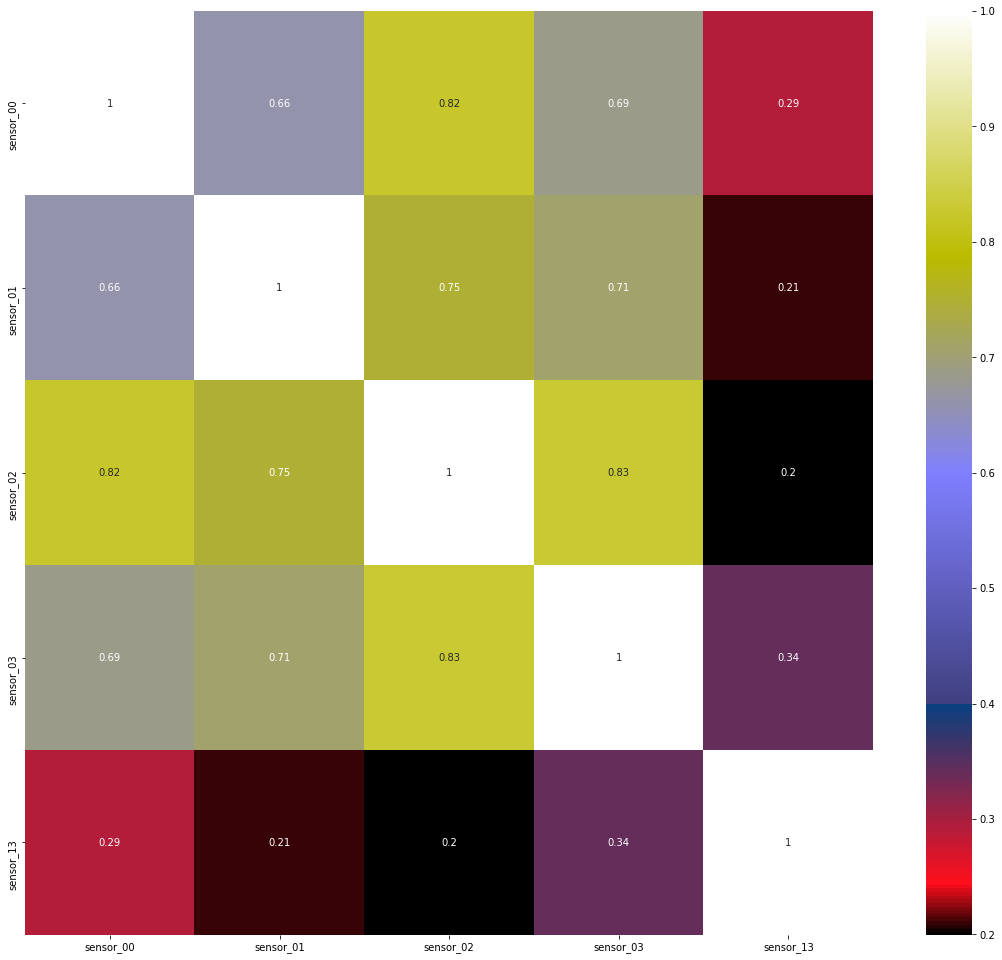

In [36]:
#sensor_data_correlations_df = sensor_data_full_df[reduced_variables].corr()
sensor_data_correlations_df = sensor_data_full_imputed_df[ssf_features].corr()
plt.figure(figsize = (19, 17))
sbn.heatmap(sensor_data_correlations_df, annot = True, cmap="gist_stern")

### 2. Loading the Failure History Data

In the data below, we have failure recordings for all the assets under observation in the specified date range. The failure can occur at any time and hence the failure data is sporadic or a non-uniform timeseries. Whenever a failure occurs, the asset ID and the date of the failure is recorded in the failure table along with the type of failure denoted by failure ID. If your failure type is a text-based descriptor, it should be converted to a categorical type.

The Sensor data is imported into the notebook from a CSV file. The CSV files for this notebook are in the subfolder 'dataset Once the dataset is imported, the asset_id column name is specified in the variable 'failure_asset_id_column_name' and the date column name is specified in the variable 'failure_date_column_name'. Finally, the format of the date needs to specified using [python's datetime format.](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

In [40]:
broken_records_df = sensor_data_full_df[sensor_data_full_df['machine_status'] == 'BROKEN']
broken_records_df.head(10)

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
95  2020-03-28  0.000000   53.342010  52.821180  43.402775  202.526031   
136 2020-05-08  1.093982   42.534720  47.699650  41.449650  206.038757   
385 2021-01-12  2.258796   47.265630  52.734370  43.446178  200.115738   
432 2021-02-28  2.321759   47.482640  51.475693  42.795135  612.152800   
711 2021-12-04  0.364005   40.190970  45.225690  40.190971  201.368622   
784 2022-02-15  0.001968   45.138890  52.907990  45.355900  500.000000   
924 2022-07-05  2.318808   45.833332  52.994790  43.880210  420.503448   

     sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_45   sensor_46  \
95   49.79289   3.219039   16.890910  16.869210  ...  51.215280  50.636570    
136  60.30106   12.304690  15.154800  14.185470  ...  31.539350  34.432870    
385  66.14643   13.592300  15.914350  15.147570  ...  37.905090  39.062500    
432  67.30158   14.062500  16.608800  15.943290  ...  57.870370  127.893500   
711  0.00000    11.335360  15.270540  15.183740  ...  28.067129  29.513889    
784  1.40131    0.028935   0.036169   0.036169   ...  35.300930  38.194440    
924  72.52040   14.185470  16.247110  15.697340  ...  52.662040  67.129630    

      sensor_47   sensor_48   sensor_49   sensor_50  sensor_51  asset_id  \
95   46.006940   409.143500  121.527800  401.909700  324.6528   pump-123   
136  33.275460   59.895830   44.560180   177.662000  183.7384   pump-123   
385  45.428240   144.675900  49.768520   246.238400  257.5231   pump-123   
432  153.935200  155.381900  65.682870   220.196800  267.3611   pump-123   
711  29.224537   29.224537   29.513889   32.407406  NaN         pump-123   
784  43.402780   99.537030   44.849540   192.129600  174.7685   pump-123   
924  43.981480   230.324100  69.733800  NaN          205.7292   pump-123   

     machine_status  target_label  
95   BROKEN          1             
136  BROKEN          1             
385  BROKEN          1             
432  BROKEN          1             
711  BROKEN          1             
784  BROKEN          1             
924  BROKEN          1             

[7 rows x 55 columns]

In [41]:
failure_asset_id_column_name = 'asset_id'               
failure_date_column_name = 'timestamp'              
failure_id_column_name = 'failure_id'                   
failure_date_format = '%Y-%m-%d %H:%M:%S'   

In [42]:
#failure_data_df = sensor_data_full_df[(sensor_data_full_df['machine_status'] == 'BROKEN') | (sensor_data_full_df['machine_status'] == 'RECOVERING')]
failure_data_df = sensor_data_full_imputed_df[(sensor_data_full_imputed_df['machine_status'] == 'BROKEN') | (sensor_data_full_imputed_df['machine_status'] == 'RECOVERING')]
failure_data_df = failure_data_df.drop_duplicates(subset=[failure_asset_id_column_name, failure_date_column_name])
failure_data_df[failure_date_column_name] = pd.to_datetime(failure_data_df[failure_date_column_name], format=failure_date_format)

# Since we are looking for failures at Machine level, we will call all types of failures as machine failures
#failure_data_df[failure_id_column_name] = 1

#failure_data_df = failure_data_df.dropna()

display(failure_data_df.head())
failure_data_df.tail()

asset_id  timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
95  pump-123 2020-03-28  0.000000   53.342010  52.821180  43.402775   
96  pump-123 2020-03-29 -0.109577   45.562064  49.468797  44.552950   
97  pump-123 2020-03-30 -0.120602   45.232927  48.042293  42.042340   
98  pump-123 2020-03-31 -0.046281   45.563753  48.720099  42.232830   
99  pump-123 2020-04-01  0.100185   46.222751  49.901377  43.956403   

     sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_44  sensor_45  \
95  202.526031  49.792890  3.219039   16.890910  ...  50.925930  51.215280   
96  3.089313    61.439108  3.013959   0.036169   ...  32.716050  33.939364   
97  3.132394    0.000000   5.729287   12.823622  ...  32.592271  83.045590   
98  3.169046    0.000000   6.638214   16.527095  ...  33.286716  33.246528   
99  154.694624  0.000000   5.285896   11.330817  ...  35.762281  35.448817   

     sensor_46  sensor_47   sensor_48   sensor_49   sensor_50   sensor_51  \
95  50.636570   46.006940  409.143500  121.527800  401.909700  324.652800   
96  33.246529   33.272249  57.142167   58.947506   68.862525   53.483475    
97  105.068481  36.517811  53.830697   46.990740   59.876543   47.805748    
98  36.545139   33.416924  34.256044   32.973251   34.963731   33.678948    
99  36.617477   35.431134  34.010095   34.039030   36.082175   36.273469    

    machine_status  target_label  
95  BROKEN          1             
96  RECOVERING      1             
97  RECOVERING      1             
98  RECOVERING      1             
99  RECOVERING      1             

[5 rows x 55 columns]

asset_id  timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
756  pump-123 2022-01-18  0.017719   39.079471  36.176093  41.368907   
757  pump-123 2022-01-19  0.109780   40.193524  37.350897  41.088131   
784  pump-123 2022-02-15  0.001968   45.138890  52.907990  45.355900   
924  pump-123 2022-07-05  2.318808   45.833332  52.994790  43.880210   
925  pump-123 2022-07-06  0.172472   46.828883  51.291231  46.587456   

      sensor_04  sensor_05  sensor_06  sensor_07  ...   sensor_44   sensor_45  \
756  57.660013   0.000000   2.142860   20.622623  ...  32.229594   32.965097    
757  194.073826  0.064744   10.987115  13.500816  ...  32.378472   33.055895    
784  500.000000  1.401310   0.028935   0.036169   ...  37.326390   35.300930    
924  420.503448  72.520400  14.185470  16.247110  ...  52.102000   52.662040    
925  72.795133   32.429265  15.117729  17.664026  ...  102.105036  103.461379   

     sensor_46  sensor_47   sensor_48   sensor_49    sensor_50   sensor_51  \
756  37.614124  36.102705  34.487831   32.463985   33.936608    34.238892    
757  36.043028  35.588576  34.240537   33.011642   35.866013    35.801334    
784  38.194440  43.402780  99.537030   44.849540   192.129600   174.768500   
924  67.129630  43.981480  230.324100  69.733800   1000.000000  205.729200   
925  68.992333  67.961516  371.509694  340.567138  1000.000000  277.361831   

     machine_status  target_label  
756  RECOVERING      1             
757  RECOVERING      1             
784  BROKEN          1             
924  BROKEN          1             
925  RECOVERING      1             

[5 rows x 55 columns]

In [43]:
#sensor_data_df = sensor_data_full_df[[sensor_asset_id_column_name, sensor_date_column_name]+list(variables_for_training)]
sensor_data_df = sensor_data_full_imputed_df[[sensor_asset_id_column_name, sensor_date_column_name]+list(variables_for_training)]
print(sensor_data_df.shape)
sensor_data_df.head()

(930, 7)


asset_id  timestamp  sensor_00  sensor_01  sensor_05   sensor_14  sensor_45
0  pump-123 2019-12-24  2.454124   48.521651  75.106401  420.190259  49.429334
1  pump-123 2019-12-25  2.454091   48.067611  72.457242  420.391610  61.837706
2  pump-123 2019-12-26  2.454162   46.882473  74.061776  420.166457  55.592528
3  pump-123 2019-12-27  2.454222   46.601319  73.439419  420.428423  50.724987
4  pump-123 2019-12-28  2.453987   47.860242  75.166017  420.204817  52.858153

In [44]:
failure_records_df = failure_data_df.reset_index(inplace = False, drop = False)[[failure_date_column_name]]
failure_records_df[failure_asset_id_column_name] = failure_data_df[failure_asset_id_column_name].unique()[0]
failure_records_df['failure_id'] = 1
print(failure_records_df.shape)
failure_records_df.head()

(86, 3)


timestamp  asset_id  failure_id
0 2020-03-28  pump-123  1         
1 2020-03-29  pump-123  1         
2 2020-03-30  pump-123  1         
3 2020-03-31  pump-123  1         
4 2020-04-01  pump-123  1

In [45]:
display(sensor_data_df.head())
display(sensor_data_df.tail())

asset_id  timestamp  sensor_00  sensor_01  sensor_05   sensor_14  sensor_45
0  pump-123 2019-12-24  2.454124   48.521651  75.106401  420.190259  49.429334
1  pump-123 2019-12-25  2.454091   48.067611  72.457242  420.391610  61.837706
2  pump-123 2019-12-26  2.454162   46.882473  74.061776  420.166457  55.592528
3  pump-123 2019-12-27  2.454222   46.601319  73.439419  420.428423  50.724987
4  pump-123 2019-12-28  2.453987   47.860242  75.166017  420.204817  52.858153

asset_id  timestamp  sensor_00  sensor_01  sensor_05   sensor_14  \
925  pump-123 2022-07-06  0.172472   46.828883  32.429265  420.123744   
926  pump-123 2022-07-07  0.614321   48.530573  56.179151  420.484764   
927  pump-123 2022-07-08  1.481401   51.983746  71.571084  420.279099   
928  pump-123 2022-07-09  2.434437   51.995079  74.302791  420.498654   
929  pump-123 2022-07-10  2.500832   51.597702  72.089349  420.435195   

      sensor_45  
925  103.461379  
926  39.850180   
927  68.042696   
928  39.634773   
929  40.473894

### Splitting training and test data based on date for WML Scoring

* **Training duration**: ```2019-02-17``` to ```2021-05-19```
* **Testing duration**: ```2021-05-20``` to ```2022-06-24```

Last known good configuration:   
train_start = datetime.strptime('2020-12-01', '%Y-%m-%d')   
train_end = datetime.strptime('2021-12-13', '%Y-%m-%d')   
test_start = datetime.strptime('2021-12-14', '%Y-%m-%d')      
test_end = datetime.strptime('2022-07-11', '%Y-%m-%d')     

In [46]:
train_start = datetime.strptime('2020-12-01', '%Y-%m-%d') 
train_end = datetime.strptime('2022-01-09', '%Y-%m-%d') 
test_start = datetime.strptime('2022-01-10', '%Y-%m-%d') 
test_end = datetime.strptime('2022-07-11', '%Y-%m-%d') 

#### Splitting Sensor Data

In [47]:
# sensor_table[sensor_date] = pd.to_datetime(sensor_table[sensor_date], format=sensor_date_format)
sensor_train_df = sensor_data_df.loc[(sensor_data_df[sensor_date_column_name] <= train_end) & (sensor_data_df[sensor_date_column_name] >= train_start)]
sensor_test_df = sensor_data_df.loc[(sensor_data_df[sensor_date_column_name] <= test_end)   &  (sensor_data_df[sensor_date_column_name] >= test_start)]

display(sensor_train_df.head())
print(sensor_train_df.shape)
display(sensor_test_df.head())
print(sensor_test_df.shape)

asset_id  timestamp  sensor_00  sensor_01  sensor_05  sensor_14  \
343  pump-123 2020-12-01  2.498739   48.939283  71.912585  37.525196   
344  pump-123 2020-12-02  2.460824   48.787374  70.321082  38.937232   
345  pump-123 2020-12-03  2.454134   48.178289  74.797855  37.982992   
346  pump-123 2020-12-04  2.454299   47.850355  76.027327  36.930347   
347  pump-123 2020-12-05  2.454233   47.848186  75.074348  37.574695   

     sensor_45  
343  37.893839  
344  36.141653  
345  37.207432  
346  36.844135  
347  43.841628

(405, 7)


asset_id  timestamp  sensor_00  sensor_01  sensor_05   sensor_14  \
748  pump-123 2022-01-10  0.002833   35.550731  86.269314  420.407073   
749  pump-123 2022-01-11  0.004460   36.303741  0.000000   420.362092   
750  pump-123 2022-01-12  0.017249   36.326918  0.000000   420.420423   
751  pump-123 2022-01-13  0.022431   36.066983  0.000000   420.505552   
752  pump-123 2022-01-14  0.019457   36.015865  0.000000   420.451571   

     sensor_45  
748  30.473572  
749  31.236995  
750  31.778870  
751  31.315908  
752  30.843300

(182, 7)


#### Splitting Failure Data

In [48]:
failure_train_df = failure_records_df.loc[(failure_records_df[failure_date_column_name] <= train_end) & (failure_records_df[failure_date_column_name] >= train_start)]
failure_test_df = failure_records_df.loc[(failure_records_df[failure_date_column_name] <= test_end)   &  (failure_records_df[failure_date_column_name] >= test_start)]

print(failure_train_df.shape)
display(failure_train_df.head())
display(failure_train_df.tail())
print(failure_test_df.shape)
display(failure_test_df.head())
display(failure_test_df.tail())

(49, 3)


timestamp  asset_id  failure_id
24 2021-01-12  pump-123  1         
25 2021-01-13  pump-123  1         
26 2021-01-14  pump-123  1         
27 2021-01-15  pump-123  1         
28 2021-01-16  pump-123  1

timestamp  asset_id  failure_id
68 2022-01-05  pump-123  1         
69 2022-01-06  pump-123  1         
70 2022-01-07  pump-123  1         
71 2022-01-08  pump-123  1         
72 2022-01-09  pump-123  1

(13, 3)


timestamp  asset_id  failure_id
73 2022-01-10  pump-123  1         
74 2022-01-11  pump-123  1         
75 2022-01-12  pump-123  1         
76 2022-01-13  pump-123  1         
77 2022-01-14  pump-123  1

timestamp  asset_id  failure_id
81 2022-01-18  pump-123  1         
82 2022-01-19  pump-123  1         
83 2022-02-15  pump-123  1         
84 2022-07-05  pump-123  1         
85 2022-07-06  pump-123  1

## Data Preparation Using our Defined Schema

In this stage, the two datasets (Sensor and Failure History) are processed and joined to generate a **Failure Prediction** table, which is ultimately used as the input for the training model. The pipeline for this stage is described in the diagram below:

[comment]: <> (the KeyTable concept is confusing in the diagram)

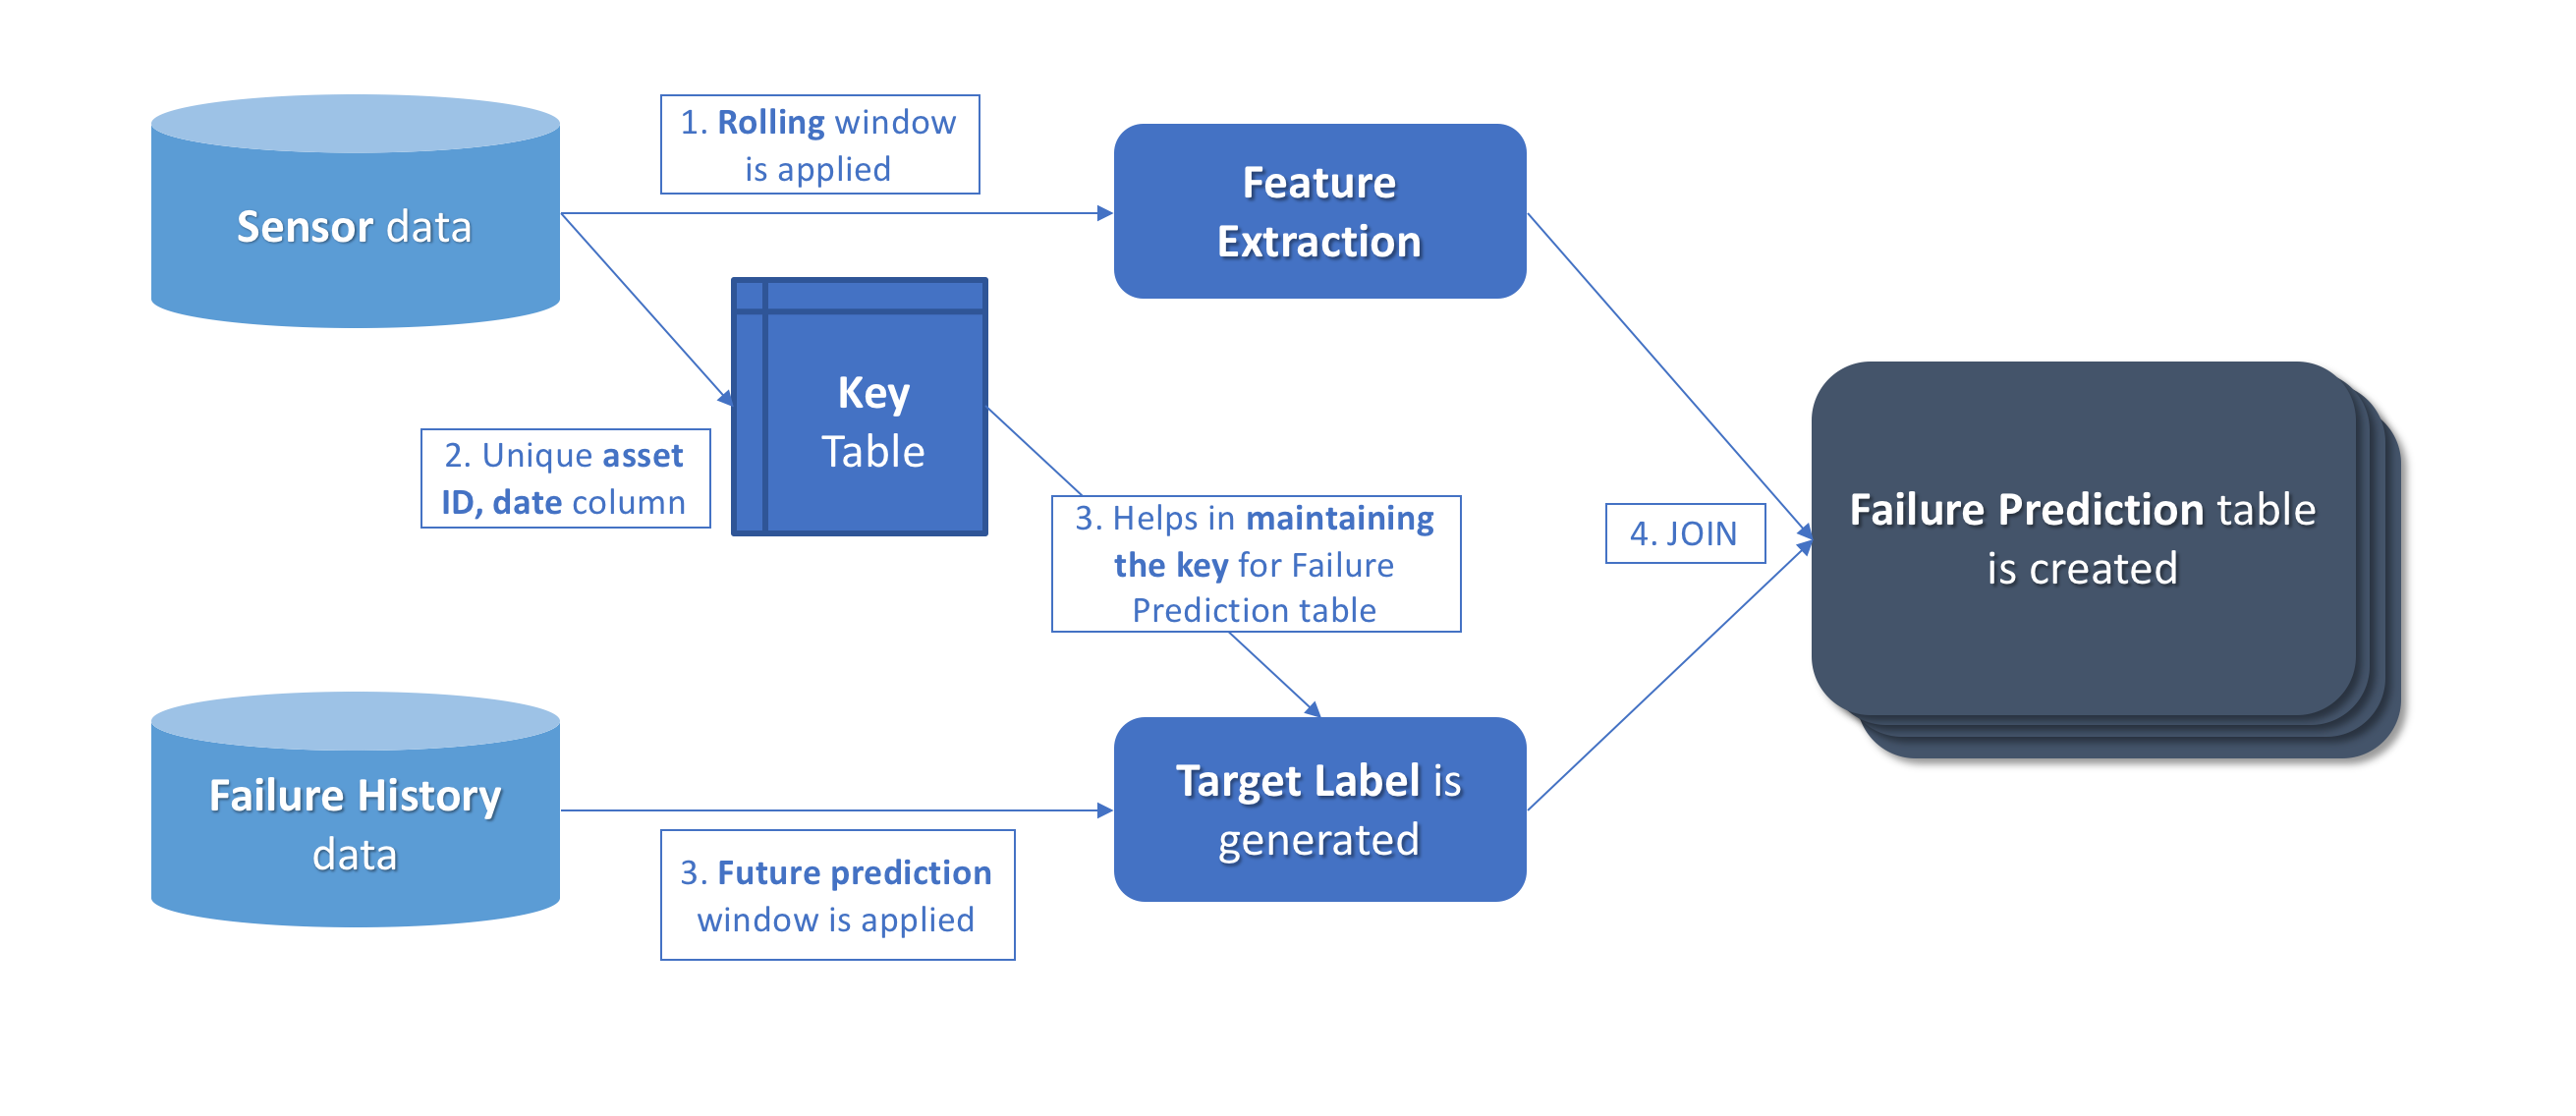

[comment]: <> (for values less than 10, it's conventional to spell them out)

The workflow has four main steps. A detailed explaination of each step in the data preparation process is presented below:


* **Feature Engineering on Sensor Data**

    * The features are generated from the sensor readings by calculating the rolling averages over a fixed window;
    * Different aggregation methods like ``mean, maximum, minimum, median, standard deviation, sum, count`` are applied over the rolling window while generating the features;
    * The table generated in this step will be used later to generate the **Failure Prediction** table.


* **Generation of Key table used in Failure Prediction table**

     * The generated key is a concatenation of `asset_id` and `downtime_date`;
     * The date range are all those from the first date until the last date in the Sensor data;
     * Note that there must be unique `asset_id` values for each asset.   


* **Target Label Generation**

    * This is a very important step since we are generating the ground truth (the values which we will compare our predictions to for assessing accuracy) for the training model. From the Failure History data, we are generating the expected target label for a future window;
    * For example, suppose a failure occurred on asset A on Date D. If we're using a prediction window of 30-days then the target column for 30-days prior to D for asset A should be "1" meaning that there is a chance of a failure occuring within the 30-day window prior to D, "0" means that there is no chance.


* **Preparation of Failure Prediction table**

    * Finally the Failure Prediction table is created by joining the the table from step 1 with target labels generated in step 3. 
    * This table is the input for the training model.
    
#### Before proceeding, it is important that the Sensor data and the Failure data are in the schema described above. If they are not, please transform your data to match the schema discussed heretofore.

[comment]: <> (Target Label Generation description is very unclear in my opinion)

### 1. Feature Engineering for Sensor Data

In this step, the features are generated from the sensor data by finding rolling averages over a fixed window size for the entire dataset. In this example, since we want to use the previous 15, 30 or 60 days sensor data to predict whether a failure event is going to take place in the future, we use a "look-back" window of 15, 30 or 60 days. We can use different aggregation methods like ``mean, maximum, minimum, median, standard deviation, sum, count`` for computing the rolling values. We also need to specify the sensors for which the rolling values will be calculated in **sensor_variables**.

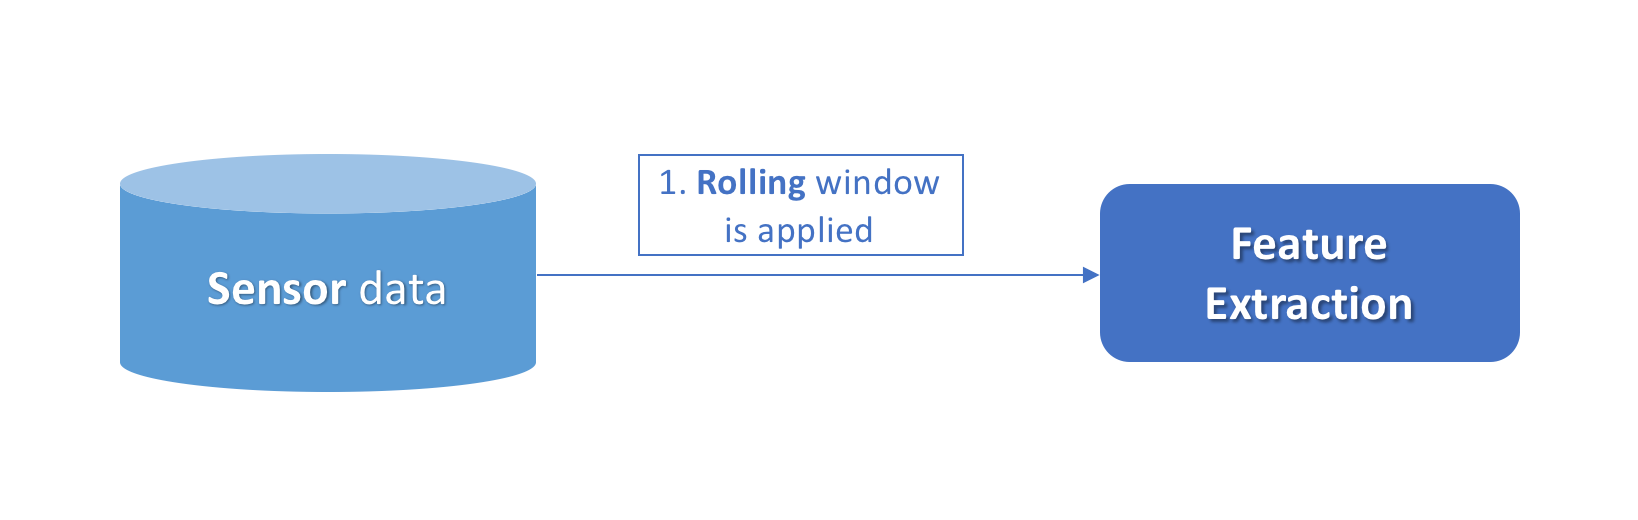

The **Sensor Features** table is returned in this step and new columns are added with names in the following format:
    * <aggregation method> _ <history window size> _ <sensor name>
    
    eg. mean_30_sensor_1 
        (for sensor_1)

##### The following should be customized the following variables as needed for the scenario / usecase / dataset

In [49]:
# Window size for rolling average
history_window_size  = '5D'

# Sampling resolution 
global_sampling_interval = '1D'

# Future prediction window size
failure_detection_window = '5D' #(days)

## aggregation methods we need
aggregation_methods = ['min','max', 'mean']

# Sensors for which features are generated
#sensor_variables = final_features

In [50]:
from srom.feature_engineering.timeseries.rolling_window_feature_extraction import simple_summary_statistics

# as before, we're going to drop NaN values which can occur
# for a number of reasons when generating rolling window values
sensor_features_df = \
simple_summary_statistics(df = sensor_train_df, rolling_window_size = history_window_size, 
                          variable_clms = variables_for_training, asset_id_clm = sensor_asset_id_column_name, 
                          date_clm = sensor_date_column_name, date_clm_format = sensor_date_format, aggregation_type = 'time', aggregation_methods = aggregation_methods)

sensor_features_df['datetime'] = pd.to_datetime(sensor_features_df['datetime'], format='%Y-%m-%d %H:%M:%S')
print(sensor_features_df.dropna().shape)
display(sensor_features_df.dropna().head())
sensor_features_df.dropna().tail()

(405, 22)


asset_id   datetime  sensor_00  sensor_01  sensor_05  sensor_14  sensor_45  \
0  pump-123 2020-12-01  2.498739   48.939283  71.912585  37.525196  37.893839   
1  pump-123 2020-12-02  2.460824   48.787374  70.321082  38.937232  36.141653   
2  pump-123 2020-12-03  2.454134   48.178289  74.797855  37.982992  37.207432   
3  pump-123 2020-12-04  2.454299   47.850355  76.027327  36.930347  36.844135   
4  pump-123 2020-12-05  2.454233   47.848186  75.074348  37.574695  43.841628   

   sensor_00__min__5D  sensor_01__min__5D  sensor_05__min__5D  ...  \
0  2.498739            48.939283           71.912585           ...   
1  2.460824            48.787374           70.321082           ...   
2  2.454134            48.178289           70.321082           ...   
3  2.454134            47.850355           70.321082           ...   
4  2.454134            47.848186           70.321082           ...   

   sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
0  2.498739            48.939283           71.912585            
1  2.498739            48.939283           71.912585            
2  2.498739            48.939283           74.797855            
3  2.498739            48.939283           76.027327            
4  2.498739            48.939283           76.027327            

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  37.525196           37.893839           2.498739              
1  38.937232           37.893839           2.479782              
2  38.937232           37.893839           2.471233              
3  38.937232           37.893839           2.466999              
4  38.937232           43.841628           2.464446              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  48.939283            71.912585            37.525196             
1  48.863328            71.116833            38.231214             
2  48.634982            72.343841            38.148474             
3  48.438825            73.264712            37.843942             
4  48.320697            73.626640            37.790093             

   sensor_45__mean__5D  
0  37.893839            
1  37.017746            
2  37.080975            
3  37.021765            
4  38.385738            

[5 rows x 22 columns]

asset_id   datetime  sensor_00  sensor_01  sensor_05   sensor_14  \
400  pump-123 2022-01-05  0.003771   33.216386  99.999878  424.365606   
401  pump-123 2022-01-06  0.003187   32.264177  99.999878  424.534158   
402  pump-123 2022-01-07  0.002785   32.466965  99.999878  424.408818   
403  pump-123 2022-01-08  0.002580   32.751735  99.999878  424.520863   
404  pump-123 2022-01-09  0.002591   33.520928  99.999878  422.230831   

     sensor_45  sensor_00__min__5D  sensor_01__min__5D  sensor_05__min__5D  \
400  27.650786  0.003771            33.216386           99.999878            
401  27.567196  0.003187            32.264177           99.999878            
402  27.369470  0.002785            32.264177           99.999878            
403  27.488427  0.002580            32.264177           99.999878            
404  28.962512  0.002580            32.264177           99.999878            

     ...  sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
400  ...  0.007596            34.743441           99.999878            
401  ...  0.006450            34.743441           99.999878            
402  ...  0.005419            34.380545           99.999878            
403  ...  0.004521            33.616655           99.999878            
404  ...  0.003771            33.520928           99.999878            

     sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
400  424.564607          31.788516           0.005552              
401  424.564607          31.788516           0.004670              
402  424.534158          31.788516           0.003937              
403  424.534158          29.145769           0.003369              
404  424.534158          28.962512           0.002983              

     sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
400  34.104985            99.999878            424.469439            
401  33.644241            99.999878            424.497053            
402  33.188946            99.999878            424.465895            
403  32.863184            99.999878            424.466039            
404  32.844038            99.999878            424.012055            

     sensor_45__mean__5D  
400  29.728009            
401  29.415510            
402  28.704347            
403  27.844330            
404  27.807678            

[5 rows x 22 columns]

### 2. Creating Uniform 'key' or date/asset entries

The failure table is a sparse matrix. Before training the model, the sensor table and the failure table should have equal number of rows. The sensor data is collected everyday for all the assets, whereas the failures occurances are sporadic and the data is sparse for failed assets and failure dates. Hence, this step ensures that the training table has uniform entries between start and end date. This table will be used in the final step of data preprocessing to generate the **Failure Prediction** table. 



We need to enter the enter the time sampling period between the start date and the end date. It can be done by modifying the 'interval' dict. If nothing is entered, then time sampling interval is set as 1 day. We also need to specify the format in which the date column is present in the sensor data. 


In [51]:
from srom.failure_prediction.preprocessing import generate_key_col

%time failure_keys_train_df = generate_key_col(sensor_train_df, sensor_date_column_name, sensor_asset_id_column_name, global_sampling_interval)
print(failure_keys_train_df.shape)
#failure_keys_train.dropna().head()
failure_keys_train_df.dropna(inplace=True)
print(failure_keys_train_df.shape)
display(failure_keys_train_df.head())
display(failure_keys_train_df.tail())

CPU times: user 633 ms, sys: 11.2 ms, total: 644 ms
Wall time: 639 ms
(405, 2)
(405, 2)


asset_id   datetime
0  pump-123 2020-12-01
1  pump-123 2020-12-02
2  pump-123 2020-12-03
3  pump-123 2020-12-04
4  pump-123 2020-12-05

asset_id   datetime
400  pump-123 2022-01-05
401  pump-123 2022-01-06
402  pump-123 2022-01-07
403  pump-123 2022-01-08
404  pump-123 2022-01-09

### 3. Generating the Failure Target table

In this step, the output result for the training model is generated. From the given data, we calculate the expected result of the model. By the expected result, we mean that if a failure occurs on date D, and we want to predict the failure in the previous X days, then flag should be raised from (D-X)th to Dth day. This result is used in the training phase to perform supervised learning and in the test phase to evaluate the results of the prediction. 

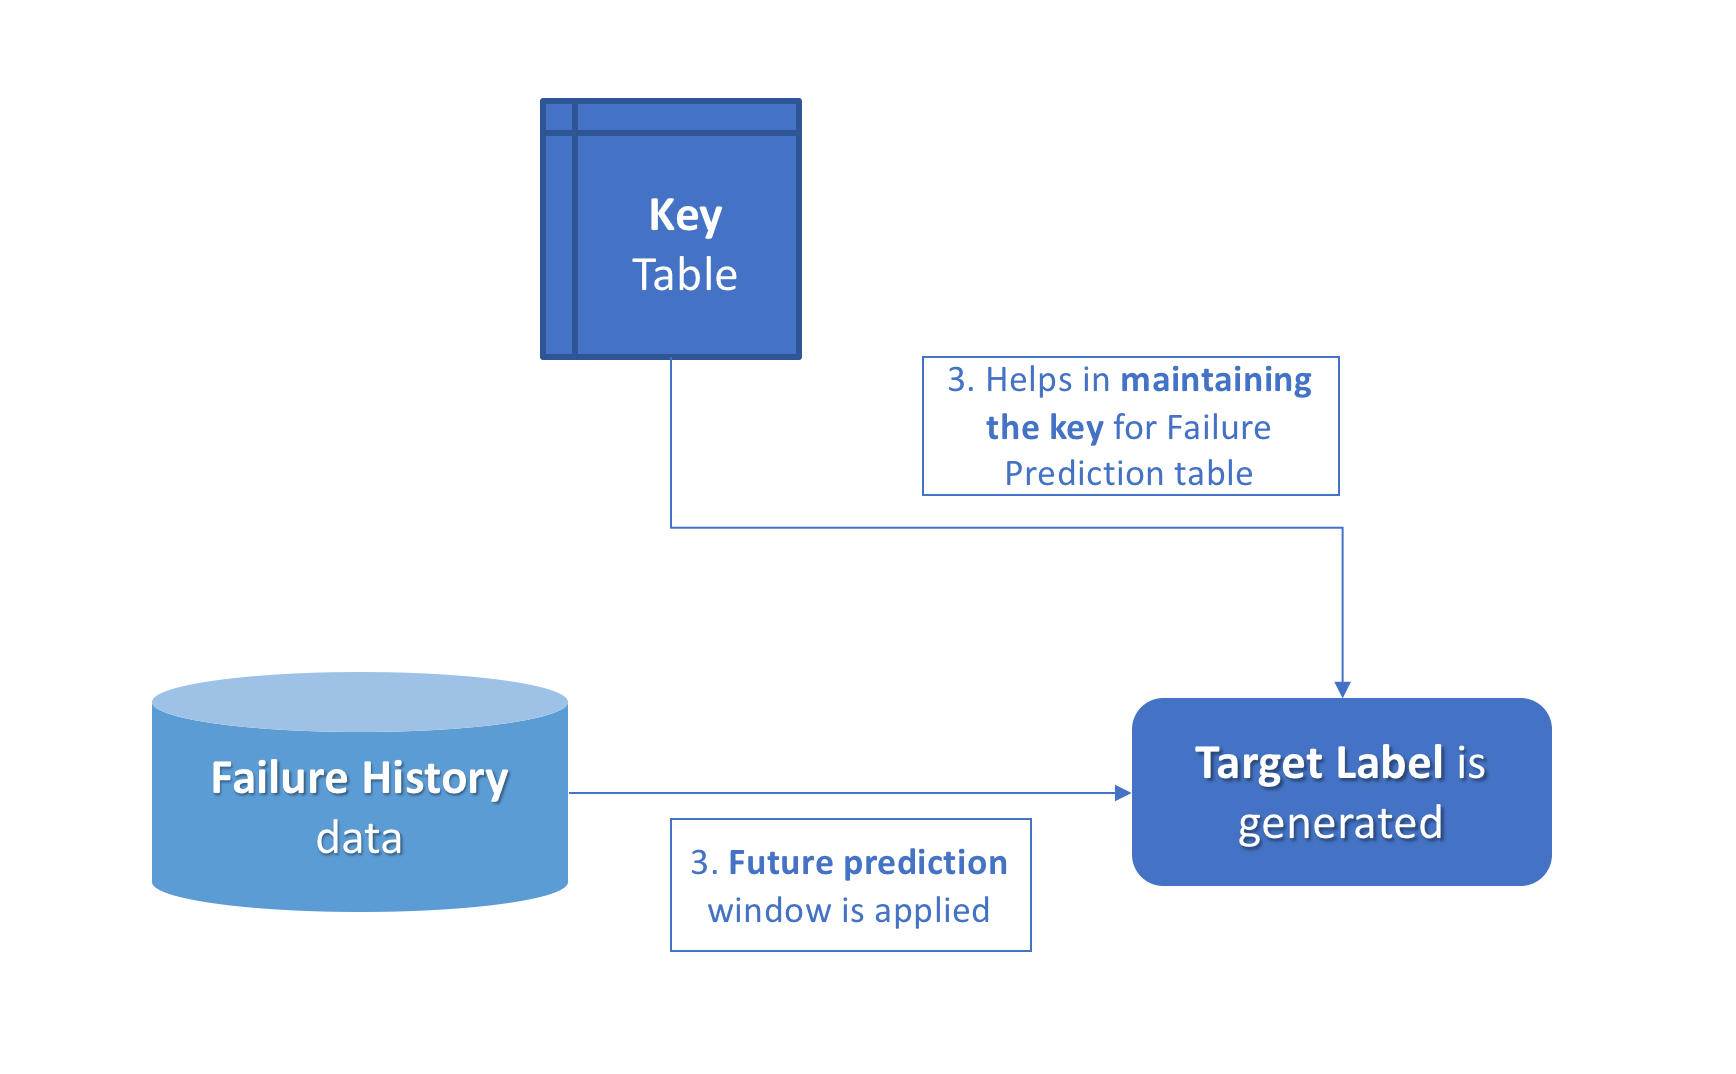
  
A future prediction window is set using which the expected target is calculated. In this example, since we want to predict the occurance of the failure within the last 15, 30 or 60, we can set that as the value for the prediction window. We also need to specify the **type of failure** for which we are predicting the occurance of a failure.

In [52]:
from srom.failure_prediction.preprocessing import generate_failure_targets

# This step doesn't cover overlapping failures of different kinds. 
# If failure type 'a' and 'b' occur at the same time, this wont work. 
# CORRECTION: It works but they should no be overlapping
# If 2 failures are overlapping or on the same period, the first failure is considered. 
# Since after the first failure, machine wont function properly and the failure detection is invalid 
# for the upcoming failures in near future.

# Generating the labels and saving them
%time failure_target_table_train_df = generate_failure_targets(failure_train_df, failure_keys_train_df, failure_detection_window, failure_asset_id_column_name, failure_date_column_name, failure_id_column_name)
print(failure_target_table_train_df.shape)
#failure_target_table_train.dropna().head()
failure_target_table_train_df.head()  # dont drop the NaNs yet

CPU times: user 120 ms, sys: 3.03 ms, total: 123 ms
Wall time: 122 ms
(405, 3)


asset_id   datetime  target_label
0  pump-123 2020-12-01  0           
1  pump-123 2020-12-02  0           
2  pump-123 2020-12-03  0           
3  pump-123 2020-12-04  0           
4  pump-123 2020-12-05  0

In [53]:
failure_target_table_train_df['target_label'].value_counts()

0    344
1    61 
Name: target_label, dtype: int64

### 4. Failure Prediction table: Combining Failure Target table and Sensor Feature table 

A **Failure Prediction** table is created by combining the Sensor Feature table (step 1) and the Failure Target table(step 3). For each unique asset ID and date combination, this table consists of expected **target label** and the **rolling average sensor features**.  




This table is finally fed into the machine learning pipeline.

In [54]:
# Note outer join, this is equivalent of a union in set operations
# Where there are no matching keys, you get NaN values
FPA_table_train_df = pd.merge(failure_target_table_train_df, sensor_features_df, on=['asset_id','datetime'], how='outer')
# let's look at some values where we have flagged a failure
display(FPA_table_train_df.head())

asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
0  pump-123 2020-12-01  0             2.498739   48.939283  71.912585   
1  pump-123 2020-12-02  0             2.460824   48.787374  70.321082   
2  pump-123 2020-12-03  0             2.454134   48.178289  74.797855   
3  pump-123 2020-12-04  0             2.454299   47.850355  76.027327   
4  pump-123 2020-12-05  0             2.454233   47.848186  75.074348   

   sensor_14  sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
0  37.525196  37.893839  2.498739            48.939283           ...   
1  38.937232  36.141653  2.460824            48.787374           ...   
2  37.982992  37.207432  2.454134            48.178289           ...   
3  36.930347  36.844135  2.454134            47.850355           ...   
4  37.574695  43.841628  2.454134            47.848186           ...   

   sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
0  2.498739            48.939283           71.912585            
1  2.498739            48.939283           71.912585            
2  2.498739            48.939283           74.797855            
3  2.498739            48.939283           76.027327            
4  2.498739            48.939283           76.027327            

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  37.525196           37.893839           2.498739              
1  38.937232           37.893839           2.479782              
2  38.937232           37.893839           2.471233              
3  38.937232           37.893839           2.466999              
4  38.937232           43.841628           2.464446              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  48.939283            71.912585            37.525196             
1  48.863328            71.116833            38.231214             
2  48.634982            72.343841            38.148474             
3  48.438825            73.264712            37.843942             
4  48.320697            73.626640            37.790093             

   sensor_45__mean__5D  
0  37.893839            
1  37.017746            
2  37.080975            
3  37.021765            
4  38.385738            

[5 rows x 23 columns]

In [55]:
FPA_table_train_df['target_label'].value_counts()

0    344
1    61 
Name: target_label, dtype: int64

#### Setting column names for training and testing datasets

In [56]:
FPA_train_clms = list(FPA_table_train_df.columns)
print(FPA_train_clms)
del FPA_train_clms[FPA_train_clms.index('datetime')]
del FPA_train_clms[FPA_train_clms.index('asset_id')]
del FPA_train_clms[FPA_train_clms.index('target_label')]

FPA_test_clms = ['target_label']

['asset_id', 'datetime', 'target_label', 'sensor_00', 'sensor_01', 'sensor_05', 'sensor_14', 'sensor_45', 'sensor_00__min__5D', 'sensor_01__min__5D', 'sensor_05__min__5D', 'sensor_14__min__5D', 'sensor_45__min__5D', 'sensor_00__max__5D', 'sensor_01__max__5D', 'sensor_05__max__5D', 'sensor_14__max__5D', 'sensor_45__max__5D', 'sensor_00__mean__5D', 'sensor_01__mean__5D', 'sensor_05__mean__5D', 'sensor_14__mean__5D', 'sensor_45__mean__5D']


In [57]:
### Since we created features, let us demonstrate training using a few of those features. 
variables_to_train_with =  variables_for_training

In [58]:
FPA_table_train_df = FPA_table_train_df.replace('nan', np.nan)
train_db = FPA_table_train_df.dropna()
train_db['target_label'] = train_db['target_label'].astype(int)
print(train_db['target_label'].value_counts())
train_pipeline = train_db[FPA_train_clms + FPA_test_clms]
train_x = train_db[variables_to_train_with].values
train_y = train_db[FPA_test_clms].values

0    344
1    61 
Name: target_label, dtype: int64


## Training the Model

Once we have transform the data into a usable format such that the model can ingest the dataframe without any problem, we move on to creating the model and plotting ROC and Precision-Recall curves to see the performance of the model.

The steps involved in modelling process are:
1. Splitting the data into training and test set. The splitting is done by date since the data is sequential. 
2. Running the SROM pipeline for the best estimator model.
3. Predicting for test data.
3. Visualizing the performance of the model.

#### Running SROM Pipeline to find the best estimator model

Choosing the attributes for the independent variables and training the model for the given data. 
We also predict the outcome for the test data using the trained model and calculate the performance of the model.

1. **Choosing independent variables (indep_var) for selecting the features that are used to train the model.**
2. New models can be used by defining the parameters and creating a pipeline for them. 

There are two different kinds of pipelines shown here. One is the legacy pipeline and the other one is SmartClassification pipeline. The execution is controlled by the flag as shown below

In [59]:
use_smart_classification = True
pipeline = SROMPipeline() # could be legacy SROM pipeline or SmartClassification
best_estimator = None # will be one of the estimators in the pipeline for legacy case, and the smart classification instance itself for SmartClassification

In [60]:
class SmartClassificationFailureError(BaseException):
    pass

def get_best_estimator(smart_clsf):
    if type(None) is not type(smart_clsf.auto_classification.best_estimator_so_far):
        return smart_clsf.auto_classification.best_estimator_so_far
    elif type(None) is not type(smart_clsf.auto_imbalanced_classification.best_estimator_so_far):
        return smart_clsf.auto_imbalanced_classification.best_estimator_so_far
    else:
        raise SmartClassificationFailureError('SmartClassification best fit unavailable')

In [61]:
from srom.utils.no_op import NoOp
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr, SelectFdr, SelectFwe, VarianceThreshold, RFE, RFECV, f_classif, mutual_info_classif
from srom.feature_engineering.model_based_feature_generator import ModelbasedFeatureGenerator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer, PolynomialFeatures, PowerTransformer
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.kernel_approximation import (
    RBFSampler,
    AdditiveChi2Sampler,
    Nystroem,
    SkewedChi2Sampler,
)
from sklearn.cluster import KMeans, FeatureAgglomeration

from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    SGDClassifier,
    RidgeClassifier,
    Perceptron,
)

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import recall_score, roc_auc_score, roc_curve, precision_recall_curve, precision_score, classification_report, confusion_matrix, precision_score, f1_score

feature_transformation_set = [('skiptransformation', NoOp()),('powertransformer', PowerTransformer()), ('normalizer', Normalizer())]

scaler_set = [('skipscaling', NoOp()),('minmaxscaler',MinMaxScaler()), ('standardscaler', StandardScaler())]

#feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=3)), ('rfecv', RFECV(estimator = LogisticRegressionCV(), min_features_to_select = 3, scoring = 'recall')),
                            #('variancethreshold', VarianceThreshold()), ('pca', PCA()), ('selectfpr', SelectFpr()), ('selectfdr', SelectFdr()), ('selectfwe', SelectFwe())]

#feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=3)), ('variancethreshold', VarianceThreshold()),('selectfpr', SelectFpr()), ('selectfdr', SelectFdr()), ('selectfwe', SelectFwe())]

feature_preprocessing_set = [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())]

estimator_feature_generator = [('skipmodelfeaturegeneration', NoOp()), ('logisticregressionclassifierfeature', ModelbasedFeatureGenerator(LogisticRegression())), \
                                                          #('randomforestclassifierfeature', ModelbasedFeatureGenerator(RandomForestClassifier())), \
                                                          #('sgdclassifierfeature', ModelbasedFeatureGenerator(SGDClassifier())),\
                                                          #('mlpclassifierfeature', ModelbasedFeatureGenerator(MLPClassifier())),\
                                                          ('ridgefeature', ModelbasedFeatureGenerator(RidgeClassifier())),
                                                          ('ldafeature', ModelbasedFeatureGenerator(LinearDiscriminantAnalysis())),
                                                          #('xgbfeature', ModelbasedFeatureGenerator(XGBClassifier())),
                                                          ('linearsvcfeature', ModelbasedFeatureGenerator(LinearSVC()))]

# Either use the full (given) estimator_set or specify your own to run fewer estimators. The more estimators inside estimator_set the longer it will take the pipeline to run.

# estimator_set = [('decisiontreeclassifier', DecisionTreeClassifier()), ('randomforestclassifier', RandomForestClassifier()), ('gradientboosting',GradientBoostingClassifier()),
#                 ('adaboosting',AdaBoostClassifier())]

random_state = 7202

estimator_set = [
    #("bernoullinb", BernoulliNB()),
            #("multinomialnb", MultinomialNB()),
            #("decisiontreeclassifier", DecisionTreeClassifier(random_state=random_state)),
            #("extratreesclassifier", ExtraTreesClassifier(random_state=random_state)),
            #("randomforestclassifier", RandomForestClassifier(random_state=random_state)),
            #("gradientboostingclassifier",GradientBoostingClassifier(random_state=random_state)),
            #("kneighborsclassifier", KNeighborsClassifier()),
              ("logisticregression", LogisticRegression(random_state=random_state)),
            #("xgbclassifier", XGBClassifier(random_state=random_state)),
            #("sgdclassifier", SGDClassifier(random_state=random_state)),
            #("svc", SVC(random_state=random_state)),
            #("perceptron", Perceptron(random_state=random_state)),
            #("mlpclassifier", MLPClassifier(random_state=random_state)),
            #("passiveaggressiveclassifier", PassiveAggressiveClassifier(random_state=random_state)),
           #("adaboostclassifier", AdaBoostClassifier(random_state=random_state)),
            #("gaussiannb", GaussianNB()),
            ("lineardiscriminantanalysis", LinearDiscriminantAnalysis()),
            #("quadraticdiscriminantanalysis", QuadraticDiscriminantAnalysis()),
            ("ridgeclassifier", CalibratedClassifierCV(RidgeClassifier(random_state=random_state))),
            #("baggingclassifier", BaggingClassifier(random_state=random_state)),
            #("nusvc", NuSVC(random_state=random_state)),
            ("linearsvc", CalibratedClassifierCV(LinearSVC()))
        ]

my_stage = [feature_transformation_set,
                       scaler_set,
                       feature_preprocessing_set,
                       estimator_feature_generator,
                       estimator_set]

print(my_stage)

[[('skiptransformation', NoOp()), ('powertransformer', PowerTransformer()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('minmaxscaler', MinMaxScaler()), ('standardscaler', StandardScaler())], [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())], [('skipmodelfeaturegeneration', NoOp()), ('logisticregressionclassifierfeature', ModelbasedFeatureGenerator(estimator=LogisticRegression())), ('ridgefeature', ModelbasedFeatureGenerator(estimator=RidgeClassifier())), ('ldafeature', ModelbasedFeatureGenerator(estimator=LinearDiscriminantAnalysis())), ('linearsvcfeature', ModelbasedFeatureGenerator(estimator=LinearSVC()))], [('logisticregression', LogisticRegression(random_state=7202)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis()), ('ridgeclassifier', CalibratedClassifierCV(base_estimator=RidgeClassifier(random_state=7202))), ('linearsvc', CalibratedClassifierCV(base_estimator=LinearSVC()))]]


In [63]:
if use_smart_classification:
    print('Using SmartClassification Pipeline @ '+str(datetime.now()))
    ## Alternatively `single_node_random_search`
    sc = SmartClassification(mode = '1', scoring='recall', stages = my_stage, execution_platform='spark_node_random_search', execution_time_per_pipeline = 5, 
                                              num_options_per_pipeline_for_random_search = 3, n_leaders_for_ensemble = 4, cv =5, total_execution_time=20)
    %time sc.fit(train_x,train_y)
    print(sc.get_experiment_info())
    pipeline.set_best_estimator(sc)
    best_estimator = get_best_estimator(sc)
else:
    #pipeline = SROMPipeline()
    pipeline.set_stages([
                    [NoOp(), StandardScaler(), RobustScaler(), MinMaxScaler()],
                    [PCA(), SelectKBest(k=10)],
                    [ DecisionTreeClassifier(),
                     RandomForestClassifier(), AdaBoostClassifier()]
                    ])
    pipeline.add_input_meta_data(label_column = 'target_label')
    from IPython.display import Image
    display(Image(pipeline.sromgraph.asimage()))
    # all pipelines need to have a scoring method
    pipeline.set_scoring('accuracy')
    warnings.filterwarnings("ignore")
    train_pipeline = train_pipeline[['target_label']+ variables_to_train_with]
    %time (pipeline.execute(train_pipeline, \
                        verbosity='low', \
                        exectype='spark_node_random_search',\
                        param_grid = SROMParamGrid(gridtype='empty')))
    pipeline.fit(train_pipeline)
    best_estimator = pipeline.best_estimator

Using SmartClassification Pipeline @ 2022-07-15 19:36:19.050665


None of the grid parameters matched for the given stages.
None of the grid parameters matched for the given stages.


CPU times: user 776 ms, sys: 179 ms, total: 955 ms
Wall time: 32.9 s
{'experiment_id': '6f9af8d4eaa74a349d1a60dee9872cdd', 'start_time': '2022-07-15T19:36:19Z', 'end_time': '2022-07-15T19:36:51Z', 'execution_time': 32.882570028305054, 'best_pipeline_info': {'model_name': 'powertransformer,logisticregression', 'model_family': 'sklearn', 'model_description': "[('powertransformer',PowerTransformer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]", 'attributes': {'coef_': [[-2.4402366712265455, -0.4636795326781071, -0.15417408454102582, 0.2800020020398576, -0.4409048399644709]], 'intercept_': [0.0]}}, 'optimization_info': {'stages': [[('skiptransformation', NoOp()), ('powertransformer', PowerTransformer()), ('normalizer', Normalizer())], [('skipscaling', NoOp()), ('minmaxscaler', MinMaxScaler()), ('standardscaler', StandardScaler())], [('skipfeaturepreprocessing', NoOp()), ('selectkbest', SelectKBest(k=4)), ('pca', PCA())], [('skipm

In [64]:
best_estimator

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('logisticregression',
                 LogisticRegression(C=0.1, fit_intercept=False, penalty='none',
                                    random_state=7202))])

In [65]:
sc.auto_classification.csv_filename

'/tmp/1000690000/smart_classification_output__335aad0765ea48858fa4ed2f9c8a4808.csv'

In [66]:
!cat $sc.auto_classification.csv_filename

round	estimator_id	execution_time_minutes	best_scores	best_estimator	n_pipelines	activation_list
1 	round	0.032619702816009524	0.7166666666666666	[('logisticregression',LogisticRegression(fit_intercept=False,random_state=7202)),]	4	None
1 	1	None	0.7166666666666666	[('logisticregression',LogisticRegression(fit_intercept=False,random_state=7202)),]		
1 	2	None	nan	[('lineardiscriminantanalysis',LinearDiscriminantAnalysis(n_components=50,shrinkage='auto',tol=0.1)),]		
1 	3	None	0.7166666666666666	[('ridgeclassifier',CalibratedClassifierCV(base_estimator=RidgeClassifier(random_state=7202))),]		
1 	4	None	0.4333333333333334	[('linearsvc',CalibratedClassifierCV(base_estimator=LinearSVC())),]		
2 	round	0.008746027946472168	0.7166666666666666	[('logisticregression',LogisticRegression(C=0.5,fit_intercept=False,penalty='none',random_state=7202)),]	4	None
2 	5	None	0.7166666666666666	[('logisticregression',LogisticRegression(C=0.5,fit_intercept=False,penalty='none',random_state=7202)),]		
2 	6	

In [67]:
filename = sc.auto_classification.csv_filename
results_csv = pd.read_csv(filename, sep="\t")
cv_results = results_csv.sort_values(["best_scores"], ascending=False)[["best_estimator", "best_scores"]].head(30)
cv_results.columns = ["Pipeline", "Score"]
cv_results = cv_results[cv_results['Pipeline'] != 'None']
cv_results.sort_values('Score', inplace = True, ascending = False) #cv_results.dropna()
cv_results.reset_index(inplace = True, drop = True)
print(cv_results.loc[3:6]['Pipeline'].values)
display(cv_results.head(50))
top_pipelines = dict(cv_results.head(5).values)
top_pipelines

["[('standardscaler',StandardScaler()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]"
 "[('pca',PCA()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]"
 "[('pca',PCA()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]"
 "[('normalizer',Normalizer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]"]


Pipeline  \
0   [('powertransformer',PowerTransformer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                        
1   [('powertransformer',PowerTransformer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                        
2   [('standardscaler',StandardScaler()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                            
3   [('standardscaler',StandardScaler()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                            
4   [('pca',PCA()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                                                  
5   [('pca',PCA()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                                                  
6   [('normalizer',Normalizer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                                    
7   [('powertransformer',PowerTransformer(method='box-cox',standardize='False')),('minmaxscaler',MinMaxScaler()),('selectkbest',SelectKBest(k=5)),('ldafeature',ModelbasedFeatureGenerator(estimator=LinearDiscriminantAnalysis())),('linearsvc',CalibratedClassifierCV(base_estimator=LinearSVC())),]                                                      
8   [('powertransformer',PowerTransformer(method='box-cox',standardize='False')),('minmaxscaler',MinMaxScaler()),('selectkbest',SelectKBest(k=5)),('ldafeature',ModelbasedFeatureGenerator(estimator=LinearDiscriminantAnalysis())),('linearsvc',CalibratedClassifierCV(base_estimator=LinearSVC())),]                                                      
9   [('selectkbest',SelectKBest(k=3)),('linearsvc',CalibratedClassifierCV(base_estimator=LinearSVC())),]                                                                                                                                                                                                                                                    
10  [('selectkbest',SelectKBest(k=4)),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]                                                                                                                                                                                                               
11  [('powertransformer',PowerTransformer(standardize='False')),('minmaxscaler',MinMaxScaler()),('pca',PCA(n_components=3)),('ldafeature',ModelbasedF

{"[('powertransformer',PowerTransformer()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]": '0.8166666666666668',
 "[('standardscaler',StandardScaler()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]": '0.8',
 "[('pca',PCA()),('logisticregression',LogisticRegression(C=0.1,fit_intercept=False,penalty='none',random_state=7202)),]": '0.8'}

### Testing and evaluation of the trained model using local scoring

The following cells perform evaluation using the test data portion, using the best estimator trained in the preceding steps. This requires the same data preparation and feature engineering as done for the training set.

In [68]:
sensor_features_test_df = simple_summary_statistics(df=sensor_test_df, rolling_window_size=history_window_size, 
                          variable_clms=variables_for_training, asset_id_clm=sensor_asset_id_column_name, 
                          date_clm=sensor_date_column_name, date_clm_format=sensor_date_format, aggregation_methods = aggregation_methods, aggregation_type='time')

sensor_features_test_df['datetime'] = pd.to_datetime(sensor_features_test_df['datetime'], format='%Y-%m-%d %H:%M:%S')
print(sensor_features_test_df.shape)
display(sensor_features_test_df.dropna().head())
sensor_features_test_df.dropna().tail()

(182, 22)


asset_id   datetime  sensor_00  sensor_01  sensor_05   sensor_14  \
0  pump-123 2022-01-10  0.002833   35.550731  86.269314  420.407073   
1  pump-123 2022-01-11  0.004460   36.303741  0.000000   420.362092   
2  pump-123 2022-01-12  0.017249   36.326918  0.000000   420.420423   
3  pump-123 2022-01-13  0.022431   36.066983  0.000000   420.505552   
4  pump-123 2022-01-14  0.019457   36.015865  0.000000   420.451571   

   sensor_45  sensor_00__min__5D  sensor_01__min__5D  sensor_05__min__5D  ...  \
0  30.473572  0.002833            35.550731           86.269314           ...   
1  31.236995  0.002833            35.550731           0.000000            ...   
2  31.778870  0.002833            35.550731           0.000000            ...   
3  31.315908  0.002833            35.550731           0.000000            ...   
4  30.843300  0.002833            35.550731           0.000000            ...   

   sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
0  0.002833            35.550731           86.269314            
1  0.004460            36.303741           86.269314            
2  0.017249            36.326918           86.269314            
3  0.022431            36.326918           86.269314            
4  0.022431            36.326918           86.269314            

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  420.407073          30.473572           0.002833              
1  420.407073          31.236995           0.003647              
2  420.420423          31.778870           0.008181              
3  420.505552          31.778870           0.011743              
4  420.505552          31.778870           0.013286              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  35.550731            86.269314            420.407073            
1  35.927236            43.134657            420.384583            
2  36.060463            28.756438            420.396529            
3  36.062093            21.567329            420.423785            
4  36.052848            17.253863            420.429342            

   sensor_45__mean__5D  
0  30.473572            
1  30.855284            
2  31.163146            
3  31.201336            
4  31.129729            

[5 rows x 22 columns]

asset_id   datetime  sensor_00  sensor_01  sensor_05   sensor_14  \
177  pump-123 2022-07-06  0.172472   46.828883  32.429265  420.123744   
178  pump-123 2022-07-07  0.614321   48.530573  56.179151  420.484764   
179  pump-123 2022-07-08  1.481401   51.983746  71.571084  420.279099   
180  pump-123 2022-07-09  2.434437   51.995079  74.302791  420.498654   
181  pump-123 2022-07-10  2.500832   51.597702  72.089349  420.435195   

      sensor_45  sensor_00__min__5D  sensor_01__min__5D  sensor_05__min__5D  \
177  103.461379  0.172472            44.733552           32.429265            
178  39.850180   0.172472            44.747296           32.429265            
179  68.042696   0.172472            45.122250           32.429265            
180  39.634773   0.172472            45.833332           32.429265            
181  40.473894   0.172472            46.828883           32.429265            

     ...  sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
177  ...  2.522710            46.828883           72.520400            
178  ...  2.496739            48.530573           72.520400            
179  ...  2.489284            51.983746           72.520400            
180  ...  2.434437            51.995079           74.302791            
181  ...  2.500832            51.995079           74.302791            

     sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
177  420.860000          103.461379          2.000002              
178  420.860000          103.461379          1.618325              
179  420.860000          103.461379          1.415257              
180  420.860000          103.461379          1.404288              
181  420.498654          103.461379          1.440692              

     sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
177  45.453063            62.843400            420.462695            
178  46.212467            60.564316            420.466893            
179  47.659757            60.912843            420.433955            
180  49.034323            61.400538            420.449252            
181  50.187197            61.314328            420.364291            

     sensor_45__mean__5D  
177  55.194269            
178  54.942855            
179  60.658840            
180  60.730213            
181  58.292584            

[5 rows x 22 columns]

In [69]:
failure_keys_test_df = generate_key_col(sensor_test_df, sensor_date_column_name, sensor_asset_id_column_name, global_sampling_interval)
print(failure_keys_test_df.shape)
display(failure_keys_test_df.dropna().head())
failure_keys_test_df.dropna().tail()

(182, 2)


asset_id   datetime
0  pump-123 2022-01-10
1  pump-123 2022-01-11
2  pump-123 2022-01-12
3  pump-123 2022-01-13
4  pump-123 2022-01-14

asset_id   datetime
177  pump-123 2022-07-06
178  pump-123 2022-07-07
179  pump-123 2022-07-08
180  pump-123 2022-07-09
181  pump-123 2022-07-10

In [70]:
from srom.failure_prediction.preprocessing import generate_failure_targets

# This step doesn't cover overlapping failures of different kinds. 
# If failure type 'a' and 'b' occur at the same time, this wont work. 
# CORRECTION: It works but they should no be overlapping
# If 2 failures are overlapping or on the same period, the first failure is considered. 
# Since after the first failure, machine wont function properly and the failure detection is invalid 
# for the upcoming failures in near future.


# Generating the labels and saving them
failure_target_table_test_df = generate_failure_targets(failure_test_df, failure_keys_test_df, failure_detection_window, failure_asset_id_column_name, failure_date_column_name, failure_id_column_name)
display(failure_target_table_test_df.dropna().head())
failure_target_table_test_df.tail(7)

asset_id   datetime  target_label
0  pump-123 2022-01-10  1           
1  pump-123 2022-01-11  1           
2  pump-123 2022-01-12  1           
3  pump-123 2022-01-13  1           
4  pump-123 2022-01-14  1

asset_id   datetime  target_label
175  pump-123 2022-07-04  1           
176  pump-123 2022-07-05  1           
177  pump-123 2022-07-06  0           
178  pump-123 2022-07-07  0           
179  pump-123 2022-07-08  0           
180  pump-123 2022-07-09  0           
181  pump-123 2022-07-10  0

In [71]:
# Note outer join, this is equivalent of a union in set operations
# Where there are no matching keys, you get NaN values
FPA_table_test_df = pd.merge(failure_target_table_test_df, sensor_features_test_df, on=['asset_id','datetime'], how='outer')
#FPA_table_test.dropna(inplace=True)
print(FPA_table_test_df.shape)
display(FPA_table_test_df.head())
# let's look at some values where we have flagged a failure
print(FPA_table_test_df[FPA_table_test_df['target_label'] == 1].dropna().shape)
display(FPA_table_test_df.loc[FPA_table_test_df['target_label'] == 1].dropna().head())
FPA_table_test_df.loc[FPA_table_test_df['target_label'] == 1].dropna().tail()

(182, 23)


asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
0  pump-123 2022-01-10  1             0.002833   35.550731  86.269314   
1  pump-123 2022-01-11  1             0.004460   36.303741  0.000000    
2  pump-123 2022-01-12  1             0.017249   36.326918  0.000000    
3  pump-123 2022-01-13  1             0.022431   36.066983  0.000000    
4  pump-123 2022-01-14  1             0.019457   36.015865  0.000000    

    sensor_14  sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
0  420.407073  30.473572  0.002833            35.550731           ...   
1  420.362092  31.236995  0.002833            35.550731           ...   
2  420.420423  31.778870  0.002833            35.550731           ...   
3  420.505552  31.315908  0.002833            35.550731           ...   
4  420.451571  30.843300  0.002833            35.550731           ...   

   sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
0  0.002833            35.550731           86.269314            
1  0.004460            36.303741           86.269314            
2  0.017249            36.326918           86.269314            
3  0.022431            36.326918           86.269314            
4  0.022431            36.326918           86.269314            

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  420.407073          30.473572           0.002833              
1  420.407073          31.236995           0.003647              
2  420.420423          31.778870           0.008181              
3  420.505552          31.778870           0.011743              
4  420.505552          31.778870           0.013286              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  35.550731            86.269314            420.407073            
1  35.927236            43.134657            420.384583            
2  36.060463            28.756438            420.396529            
3  36.062093            21.567329            420.423785            
4  36.052848            17.253863            420.429342            

   sensor_45__mean__5D  
0  30.473572            
1  30.855284            
2  31.163146            
3  31.201336            
4  31.129729            

[5 rows x 23 columns]

(20, 23)


asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
0  pump-123 2022-01-10  1             0.002833   35.550731  86.269314   
1  pump-123 2022-01-11  1             0.004460   36.303741  0.000000    
2  pump-123 2022-01-12  1             0.017249   36.326918  0.000000    
3  pump-123 2022-01-13  1             0.022431   36.066983  0.000000    
4  pump-123 2022-01-14  1             0.019457   36.015865  0.000000    

    sensor_14  sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
0  420.407073  30.473572  0.002833            35.550731           ...   
1  420.362092  31.236995  0.002833            35.550731           ...   
2  420.420423  31.778870  0.002833            35.550731           ...   
3  420.505552  31.315908  0.002833            35.550731           ...   
4  420.451571  30.843300  0.002833            35.550731           ...   

   sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
0  0.002833            35.550731           86.269314            
1  0.004460            36.303741           86.269314            
2  0.017249            36.326918           86.269314            
3  0.022431            36.326918           86.269314            
4  0.022431            36.326918           86.269314            

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  420.407073          30.473572           0.002833              
1  420.407073          31.236995           0.003647              
2  420.420423          31.778870           0.008181              
3  420.505552          31.778870           0.011743              
4  420.505552          31.778870           0.013286              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  35.550731            86.269314            420.407073            
1  35.927236            43.134657            420.384583            
2  36.060463            28.756438            420.396529            
3  36.062093            21.567329            420.423785            
4  36.052848            17.253863            420.429342            

   sensor_45__mean__5D  
0  30.473572            
1  30.855284            
2  31.163146            
3  31.201336            
4  31.129729            

[5 rows x 23 columns]

asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
172  pump-123 2022-07-01  1             2.522732   44.343653  69.444939   
173  pump-123 2022-07-02  1             2.522710   44.733552  67.574572   
174  pump-123 2022-07-03  1             2.496739   44.747296  69.828448   
175  pump-123 2022-07-04  1             2.489284   45.122250  71.864315   
176  pump-123 2022-07-05  1             2.318808   45.833332  72.520400   

      sensor_14  sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
172  420.491659  46.185378  2.453867            44.343653           ...   
173  420.463774  41.107253  2.453867            44.343653           ...   
174  420.443789  39.462770  2.471116            44.343653           ...   
175  420.422169  39.277906  2.489284            44.343653           ...   
176  420.860000  52.662040  2.318808            44.343653           ...   

     sensor_00__max__5D  sensor_01__max__5D  sensor_05__max__5D  \
172  2.522891            46.085068           70.524147            
173  2.522891            46.085068           70.524147            
174  2.522891            45.473088           70.524147            
175  2.522891            45.122250           71.864315            
176  2.522732            45.833332           72.520400            

     sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
172  420.491659          46.185378           2.484907              
173  420.491659          46.185378           2.498663              
174  420.491659          46.185378           2.507238              
175  420.491659          46.185378           2.510871              
176  420.860000          52.662040           2.470055              

     sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
172  45.261959            69.101142            419.986139            
173  45.012344            68.744934            419.993205            
174  44.744790            69.088427            420.428825            
175  44.674622            69.847284            420.438182            
176  44.956017            70.246535            420.536278            

     sensor_45__mean__5D  
172  43.075488            
173  42.213541            
174  41.381494            
175  41.063528            
176  43.739069            

[5 rows x 23 columns]

In [72]:
result_series = FPA_table_test_df.isna().sum()
for key in result_series.keys():
    print(key, result_series[key])

asset_id 0
datetime 0
target_label 0
sensor_00 0
sensor_01 0
sensor_05 0
sensor_14 0
sensor_45 0
sensor_00__min__5D 0
sensor_01__min__5D 0
sensor_05__min__5D 0
sensor_14__min__5D 0
sensor_45__min__5D 0
sensor_00__max__5D 0
sensor_01__max__5D 0
sensor_05__max__5D 0
sensor_14__max__5D 0
sensor_45__max__5D 0
sensor_00__mean__5D 0
sensor_01__mean__5D 0
sensor_05__mean__5D 0
sensor_14__mean__5D 0
sensor_45__mean__5D 0


In [73]:
FPA_table_test_df = FPA_table_test_df.replace('nan', np.nan)
test_db = FPA_table_test_df.dropna()

test_pipeline = test_db[FPA_train_clms + FPA_test_clms]
test_x = test_db[variables_to_train_with].values
test_y = test_db[FPA_test_clms].values

In [74]:
best_estimator.score(test_x, test_y)

0.8241758241758241

In [75]:
# Logistic Regresson with Select K Best (k = 5)
y_pred = sc.predict(test_x)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1
 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0]


In [76]:
y_prob = sc.predict_proba(test_x)
print(y_prob)

[[4.37045189e-04 9.99562955e-01]
 [2.60856908e-04 9.99739143e-01]
 [2.75089163e-04 9.99724911e-01]
 [2.61708562e-04 9.99738291e-01]
 [2.49707956e-04 9.99750292e-01]
 [2.44628533e-04 9.99755371e-01]
 [2.50135174e-04 9.99749865e-01]
 [3.01099405e-04 9.99698901e-01]
 [3.26318499e-04 9.99673682e-01]
 [3.42871393e-04 9.99657129e-01]
 [7.55569705e-04 9.99244430e-01]
 [3.01304931e-03 9.96986951e-01]
 [1.17087480e-01 8.82912520e-01]
 [8.22553605e-01 1.77446395e-01]
 [8.88374816e-01 1.11625184e-01]
 [7.33363091e-01 2.66636909e-01]
 [8.09178074e-01 1.90821926e-01]
 [7.17367842e-01 2.82632158e-01]
 [7.93239766e-01 2.06760234e-01]
 [8.92768285e-01 1.07231715e-01]
 [8.56496084e-01 1.43503916e-01]
 [7.01001074e-01 2.98998926e-01]
 [8.09023971e-01 1.90976029e-01]
 [6.68546081e-01 3.31453919e-01]
 [5.53076852e-01 4.46923148e-01]
 [5.86672443e-01 4.13327557e-01]
 [4.71604253e-01 5.28395747e-01]
 [4.38974101e-01 5.61025899e-01]
 [3.21739888e-01 6.78260112e-01]
 [4.16961655e-01 5.83038345e-01]
 [6.599189

In [77]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([146,  36]))

In [78]:
# select k best with k = 5, LogisticRegression
train_pred = sc.predict(train_x)
print('Recall for training data segment = ', str(recall_score(train_db['target_label'].values, train_pred)))
print('Recall for test data segment = ', str(recall_score(test_db['target_label'].values, y_pred))) 

Recall for training data segment =  0.819672131147541
Recall for test data segment =  0.6


In [79]:
f1_score(test_db['target_label'].values, y_pred)

0.42857142857142855

In [80]:
results_df = test_db.copy()
results_df['class_label'] = y_pred
if len(y_prob.shape) == 2:
    results_df['class_0_probability'] = [item[0] for item in y_prob]
    results_df['class_1_probability'] = [item[1] for item in y_prob]
else:
    results_df['score'] = y_prob
print(results_df.shape)
display(results_df.head())
results_df.tail()

(182, 26)


asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
0  pump-123 2022-01-10  1             0.002833   35.550731  86.269314   
1  pump-123 2022-01-11  1             0.004460   36.303741  0.000000    
2  pump-123 2022-01-12  1             0.017249   36.326918  0.000000    
3  pump-123 2022-01-13  1             0.022431   36.066983  0.000000    
4  pump-123 2022-01-14  1             0.019457   36.015865  0.000000    

    sensor_14  sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
0  420.407073  30.473572  0.002833            35.550731           ...   
1  420.362092  31.236995  0.002833            35.550731           ...   
2  420.420423  31.778870  0.002833            35.550731           ...   
3  420.505552  31.315908  0.002833            35.550731           ...   
4  420.451571  30.843300  0.002833            35.550731           ...   

   sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
0  420.407073          30.473572           0.002833              
1  420.407073          31.236995           0.003647              
2  420.420423          31.778870           0.008181              
3  420.505552          31.778870           0.011743              
4  420.505552          31.778870           0.013286              

   sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
0  35.550731            86.269314            420.407073            
1  35.927236            43.134657            420.384583            
2  36.060463            28.756438            420.396529            
3  36.062093            21.567329            420.423785            
4  36.052848            17.253863            420.429342            

   sensor_45__mean__5D  class_label  class_0_probability  class_1_probability  
0  30.473572            1            0.000437             0.999563             
1  30.855284            1            0.000261             0.999739             
2  31.163146            1            0.000275             0.999725             
3  31.201336            1            0.000262             0.999738             
4  31.129729            1            0.000250             0.999750             

[5 rows x 26 columns]

asset_id   datetime  target_label  sensor_00  sensor_01  sensor_05  \
177  pump-123 2022-07-06  0             0.172472   46.828883  32.429265   
178  pump-123 2022-07-07  0             0.614321   48.530573  56.179151   
179  pump-123 2022-07-08  0             1.481401   51.983746  71.571084   
180  pump-123 2022-07-09  0             2.434437   51.995079  74.302791   
181  pump-123 2022-07-10  0             2.500832   51.597702  72.089349   

      sensor_14   sensor_45  sensor_00__min__5D  sensor_01__min__5D  ...  \
177  420.123744  103.461379  0.172472            44.733552           ...   
178  420.484764  39.850180   0.172472            44.747296           ...   
179  420.279099  68.042696   0.172472            45.122250           ...   
180  420.498654  39.634773   0.172472            45.833332           ...   
181  420.435195  40.473894   0.172472            46.828883           ...   

     sensor_14__max__5D  sensor_45__max__5D  sensor_00__mean__5D  \
177  420.860000          103.461379          2.000002              
178  420.860000          103.461379          1.618325              
179  420.860000          103.461379          1.415257              
180  420.860000          103.461379          1.404288              
181  420.498654          103.461379          1.440692              

     sensor_01__mean__5D  sensor_05__mean__5D  sensor_14__mean__5D  \
177  45.453063            62.843400            420.462695            
178  46.212467            60.564316            420.466893            
179  47.659757            60.912843            420.433955            
180  49.034323            61.400538            420.449252            
181  50.187197            61.314328            420.364291            

     sensor_45__mean__5D  class_label  class_0_probability  \
177  55.194269            1            0.037124              
178  54.942855            1            0.002289              
179  60.658840            1            0.129664              
180  60.730213            0            0.871960              
181  58.292584            0            0.927808              

     class_1_probability  
177  0.962876             
178  0.997711             
179  0.870336             
180  0.128040             
181  0.072192             

[5 rows x 26 columns]

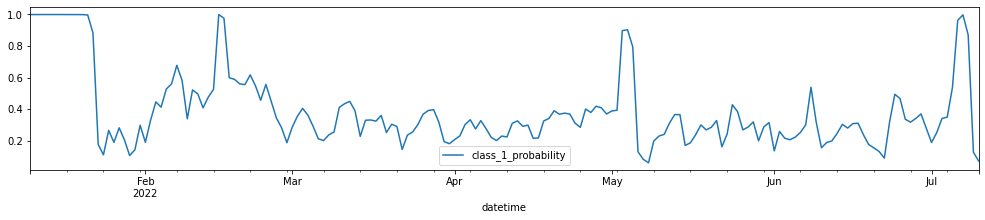

In [81]:
results_df.set_index(['datetime'], inplace = True)
if len(y_prob.shape) == 2:
    results_df[['class_1_probability']].plot(figsize = (17,3))
else:
    results_df['score'].plot(figsize = (17,3))

In [82]:
failure_records_ts = [pd.to_datetime(ts) for ts in broken_records_df['timestamp'].values]
print(failure_records_ts)
### extend the range a little to make sure the predictions that fall off the range are also printed
failure_records_ts = np.concatenate((failure_records_ts, [pd.to_datetime(np.max(failure_records_ts)+pd.Timedelta(days = n)) for n in range(1,4)]))
print(failure_records_ts)

if len(y_prob.shape) == 2:
    display(results_df[results_df.index.isin(failure_records_ts)][['asset_id','class_label','class_1_probability','class_0_probability']].head(10))
else:
    display(results_df[results_df.index.isin(failure_records_ts)][['asset_id','class_label','score']].head(10))

[Timestamp('2020-03-28 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-02-28 00:00:00'), Timestamp('2021-12-04 00:00:00'), Timestamp('2022-02-15 00:00:00'), Timestamp('2022-07-05 00:00:00')]
[Timestamp('2020-03-28 00:00:00') Timestamp('2020-05-08 00:00:00')
 Timestamp('2021-01-12 00:00:00') Timestamp('2021-02-28 00:00:00')
 Timestamp('2021-12-04 00:00:00') Timestamp('2022-02-15 00:00:00')
 Timestamp('2022-07-05 00:00:00') Timestamp('2022-07-06 00:00:00')
 Timestamp('2022-07-07 00:00:00') Timestamp('2022-07-08 00:00:00')]


asset_id  class_label  class_1_probability  class_0_probability
datetime                                                                   
2022-02-15  pump-123  1            0.999404             0.000596           
2022-07-05  pump-123  1            0.538926             0.461074           
2022-07-06  pump-123  1            0.962876             0.037124           
2022-07-07  pump-123  1            0.997711             0.002289           
2022-07-08  pump-123  1            0.870336             0.129664

In [83]:
ts_window = [pd.to_datetime('2022-07-05') - pd.Timedelta(days = ndays) for ndays in range(1, 7)]
print(ts_window)
display(results_df[results_df.index.isin(ts_window)][['asset_id','class_label','class_1_probability','class_0_probability']].head(10))

[Timestamp('2022-07-04 00:00:00'), Timestamp('2022-07-03 00:00:00'), Timestamp('2022-07-02 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-06-29 00:00:00')]


asset_id  class_label  class_1_probability  class_0_probability
datetime                                                                   
2022-06-29  pump-123  0            0.370756             0.629244           
2022-06-30  pump-123  0            0.280329             0.719671           
2022-07-01  pump-123  0            0.189812             0.810188           
2022-07-02  pump-123  0            0.252155             0.747845           
2022-07-03  pump-123  0            0.341785             0.658215           
2022-07-04  pump-123  0            0.350539             0.649461

###### Compare the trend in values of the sensors before each failure for further analysis

In [84]:
ts_window = sorted([pd.to_datetime('2022-02-15') - pd.Timedelta(days = ndays) for ndays in range(-7, 7)])
print(ts_window)
feb15_analysis_df = results_df[results_df.index.isin(ts_window)][['asset_id','class_label','class_1_probability','class_0_probability'] + variables_for_training]
display(feb15_analysis_df.head(15))
display(feb15_analysis_df.describe())
sensor_data_full_imputed_df[(sensor_data_full_imputed_df[sensor_date_column_name].isin(ts_window)) & (sensor_data_full_imputed_df['machine_status'] == 'RECOVERING')].head()

[Timestamp('2022-02-09 00:00:00'), Timestamp('2022-02-10 00:00:00'), Timestamp('2022-02-11 00:00:00'), Timestamp('2022-02-12 00:00:00'), Timestamp('2022-02-13 00:00:00'), Timestamp('2022-02-14 00:00:00'), Timestamp('2022-02-15 00:00:00'), Timestamp('2022-02-16 00:00:00'), Timestamp('2022-02-17 00:00:00'), Timestamp('2022-02-18 00:00:00'), Timestamp('2022-02-19 00:00:00'), Timestamp('2022-02-20 00:00:00'), Timestamp('2022-02-21 00:00:00'), Timestamp('2022-02-22 00:00:00')]


asset_id  class_label  class_1_probability  class_0_probability  \
datetime                                                                      
2022-02-09  pump-123  0            0.340081             0.659919              
2022-02-10  pump-123  1            0.522430             0.477570              
2022-02-11  pump-123  0            0.497664             0.502336              
2022-02-12  pump-123  0            0.409157             0.590843              
2022-02-13  pump-123  0            0.476749             0.523251              
2022-02-14  pump-123  1            0.526055             0.473945              
2022-02-15  pump-123  1            0.999404             0.000596              
2022-02-16  pump-123  1            0.976205             0.023795              
2022-02-17  pump-123  1            0.599657             0.400343              
2022-02-18  pump-123  1            0.589523             0.410477              
2022-02-19  pump-123  1            0.561052             0.438948              
2022-02-20  pump-123  1            0.556019             0.443981              
2022-02-21  pump-123  1            0.617684             0.382316              
2022-02-22  pump-123  1            0.549388             0.450612              

            sensor_00  sensor_01  sensor_05   sensor_14  sensor_45  
datetime                                                            
2022-02-09  2.403535   43.563849  92.292084  404.643926  49.011381  
2022-02-10  2.403371   44.447820  92.712558  420.331367  40.200617  
2022-02-11  2.403414   45.448493  96.639524  420.481482  39.232895  
2022-02-12  2.432398   46.074218  90.526478  420.490009  39.771412  
2022-02-13  2.403808   45.887585  85.622356  420.461038  41.509130  
2022-02-14  2.403568   45.613183  82.855622  420.372122  40.022183  
2022-02-15  0.001968   45.138890  1.401310   421.661800  35.300930  
2022-02-16  2.054544   43.790989  71.421475  420.388937  36.339377  
2022-02-17  2.399490   44.228877  77.246456  420.531959  39.811599  
2022-02-18  2.376158   44.874371  77.367450  420.490919  42.541152  
2022-02-19  2.399643   45.517937  77.994634  420.457174  39.766589  
2022-02-20  2.399457   45.663336  80.101310  420.365168  39.451517  
2022-02-21  2.399414   45.293690  71.987747  420.503402  38.218556  
2022-02-22  2.402283   45.502987  87.294687  420.461088  38.495048

class_label  class_1_probability  class_0_probability  sensor_00  \
count  14.000000    14.000000            14.000000            14.000000   
mean   0.714286     0.587219             0.412781             2.205932    
std    0.468807     0.185292             0.185292             0.641172    
min    0.000000     0.340081             0.000596             0.001968    
25%    0.250000     0.503855             0.402876             2.399425    
50%    1.000000     0.552703             0.447297             2.400963    
75%    1.000000     0.597124             0.496145             2.403505    
max    1.000000     0.999404             0.659919             2.432398    

       sensor_01  sensor_05   sensor_14  sensor_45  
count  14.000000  14.000000  14.000000   14.000000  
mean   45.074730  77.533121  419.402885  39.976599  
std    0.781865   23.274700  4.260691    3.185597   
min    43.563849  1.401310   404.643926  35.300930  
25%    44.554457  77.276705  420.376326  38.679510  
50%    45.371091  81.478466  420.461063  39.769000  
75%    45.589371  89.718530  420.490692  40.156008  
max    46.074218  96.639524  421.661800  49.011381

Empty DataFrame
Columns: [asset_id, timestamp, sensor_00, sensor_01, sensor_02, sensor_03, sensor_04, sensor_05, sensor_06, sensor_07, sensor_08, sensor_09, sensor_10, sensor_11, sensor_12, sensor_13, sensor_14, sensor_16, sensor_17, sensor_18, sensor_19, sensor_20, sensor_21, sensor_22, sensor_23, sensor_24, sensor_25, sensor_26, sensor_27, sensor_28, sensor_29, sensor_30, sensor_31, sensor_32, sensor_33, sensor_34, sensor_35, sensor_36, sensor_37, sensor_38, sensor_39, sensor_40, sensor_41, sensor_42, sensor_43, sensor_44, sensor_45, sensor_46, sensor_47, sensor_48, sensor_49, sensor_50, sensor_51, machine_status, target_label]
Index: []

[0 rows x 55 columns]

In [85]:
ts_window = sorted([pd.to_datetime('2022-07-05') - pd.Timedelta(days = ndays) for ndays in range(-7, 3)])
print(ts_window)
july5_analysis_df = results_df[results_df.index.isin(ts_window)][['asset_id','class_label','class_1_probability','class_0_probability'] + variables_for_training]
display(july5_analysis_df.head(10))
display(july5_analysis_df.describe())

[Timestamp('2022-07-03 00:00:00'), Timestamp('2022-07-04 00:00:00'), Timestamp('2022-07-05 00:00:00'), Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-07 00:00:00'), Timestamp('2022-07-08 00:00:00'), Timestamp('2022-07-09 00:00:00'), Timestamp('2022-07-10 00:00:00'), Timestamp('2022-07-11 00:00:00'), Timestamp('2022-07-12 00:00:00')]


asset_id  class_label  class_1_probability  class_0_probability  \
datetime                                                                      
2022-07-03  pump-123  0            0.341785             0.658215              
2022-07-04  pump-123  0            0.350539             0.649461              
2022-07-05  pump-123  1            0.538926             0.461074              
2022-07-06  pump-123  1            0.962876             0.037124              
2022-07-07  pump-123  1            0.997711             0.002289              
2022-07-08  pump-123  1            0.870336             0.129664              
2022-07-09  pump-123  0            0.128040             0.871960              
2022-07-10  pump-123  0            0.072192             0.927808              

            sensor_00  sensor_01  sensor_05   sensor_14   sensor_45  
datetime                                                             
2022-07-03  2.496739   44.747296  69.828448  420.443789  39.462770   
2022-07-04  2.489284   45.122250  71.864315  420.422169  39.277906   
2022-07-05  2.318808   45.833332  72.520400  420.860000  52.662040   
2022-07-06  0.172472   46.828883  32.429265  420.123744  103.461379  
2022-07-07  0.614321   48.530573  56.179151  420.484764  39.850180   
2022-07-08  1.481401   51.983746  71.571084  420.279099  68.042696   
2022-07-09  2.434437   51.995079  74.302791  420.498654  39.634773   
2022-07-10  2.500832   51.597702  72.089349  420.435195  40.473894

class_label  class_1_probability  class_0_probability  sensor_00  \
count  8.000000     8.000000             8.000000             8.000000    
mean   0.500000     0.532801             0.467199             1.813537    
std    0.534522     0.370477             0.370477             0.947034    
min    0.000000     0.072192             0.002289             0.172472    
25%    0.000000     0.288348             0.106529             1.264631    
50%    0.500000     0.444732             0.555268             2.376622    
75%    1.000000     0.893471             0.711652             2.491147    
max    1.000000     0.997711             0.927808             2.500832    

       sensor_01  sensor_05   sensor_14   sensor_45  
count  8.000000   8.000000   8.000000    8.000000    
mean   48.329858  65.098100  420.443427  52.858205   
std    3.142176   14.370368  0.209766    22.842910   
min    44.747296  32.429265  420.123744  39.277906   
25%    45.655561  66.416124  420.386402  39.591772   
50%    47.679728  71.717699  420.439492  40.162037   
75%    51.694213  72.197112  420.488237  56.507204   
max    51.995079  74.302791  420.860000  103.461379

### WML Deployment and Scoring


#### 1. Credentials for Watson Machine Learning Service
    
**NOTE: The following cell should be modified with appropriate credentials to connect to the WML service**

In [53]:
# @hidden_cell
deployment_space = 'MAS-Testing-Deployment-Space'
 # Change into your own wml credentials for the following code
wml_credentials = {
                   "url":  os.environ['RUNTIME_ENV_APSX_URL'], 
                   "token": os.environ['USER_ACCESS_TOKEN'],
                   "instance_id": "wml_local",
                   "version" : "4.0"
                  } 

### Deploying Featuring Engineering on WML

#### Creating Feature Engineering custom function 

In [54]:
from srom.utils.custom_function_estimator import CustomFunctionEstimator
from srom.feature_engineering.timeseries.rolling_window_feature_extraction import simple_summary_statistics

custom_function_args = {
    'aggregation_methods': aggregation_methods,
    'rolling_window_size': history_window_size,
    'variable_clms': sensor_variables,
    'asset_id_clm': sensor_asset_id_column_name,
    'date_clm': sensor_date_column_name,
    'date_clm_format': sensor_date_format
}

CF1 = CustomFunctionEstimator(custom_function=simple_summary_statistics,
                              custom_function_args=custom_function_args, 
                              column_names=list(sensor_test.columns))

#### Putting it in Sklearn pipeline

In [55]:
from sklearn.pipeline import Pipeline
from srom.pipeline.srom_pipeline import SROMPipeline

skpipeline = Pipeline(steps=[('CFT', CF1)])
fe_pipeline = SROMPipeline()
fe_pipeline.set_best_estimator(skpipeline)

#### Deploying Feature engineering pipeline

##### WMLScorer 



This is the main class in srom library which allows users to deploy and score the SROM Pipeline on WML. It enables deployment and scoring seemless on WML. The step to score a test data using a model deployed on WML are:

* Create an object for **`WMLScorer`**.
* Provide **wml_credentials** to WMLScorer object and call the `connect()` function.
* Add the source to SROM libary (`key` and `version` required) 
* Create **runtime environment**. Returns a Runtime unique ID.



In [ ]:
!pip install wget
import wget
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

pmlib_version=pmlib.__version__
pmlib_zip_file='pmlib-'+pmlib_version+'.zip'
print(pmlib_zip_file)
apm_api_url=os.environ['APM_API_BASEURL']
apm_id=os.environ['APM_ID']
apm_api_key=os.environ['APM_API_KEY']
pmlib_download_url = apm_api_url+"/ibm/pmi/service/rest/ds/"+apm_id+"/"+apm_api_key+"/lib/download?filename="+'pmlib'
print(pmlib_download_url)
try:
    wget.download(pmlib_download_url, pmlib_zip_file)
except Exception as ex:
    print('Error while downloading with the message ', ex)

In [ ]:
from srom.wml.wrappers.onprem.scoring import WMLScorer
wml_scorer_feature_engg = WMLScorer()
wml_scorer_feature_engg.connect(wml_credentials=wml_credentials, deployment_space_name = deployment_space)
wml_scorer_feature_engg.add_local_package(pmlib_zip_file, str(pmlib_version), 'pmlib custom package')
fe_model_details, fe_deployment_details = wml_scorer_feature_engg.deploy_model(model_object = fe_pipeline, model_name='fpa_feature_engg_deployment', \
                                                                    model_description  =  'Feature Engineering for FPA Pipeline based on ' + srom_version_tag + ',' + dqlearn_version_tag, \
                                                                    model_type  = 'scikit-learn_0.23', randomize_name = True, software_spec_name=srom_version_tag + '_' + dqlearn_version_tag, \
                                                                    software_spec_description='Software Spec with SROM annd DQLearn',  \
                                                                    software_spec_type='default_py3.8', list_existing=True)

In [58]:
fe_model_details

{'entity': {'software_spec': {'id': '9b770d6f-123f-4689-b9f8-dd67fa9fe1eb',
   'name': 'srom-1.4.0rc7_dqlearn-0.4.2'},
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2022-02-07T12:01:32.853Z',
  'description': 'Feature Engineering for FPA Pipeline based on srom-1.4.0rc7,dqlearn-0.4.2',
  'id': 'c1fcbc3e-f810-479a-817b-1d33a867a2a8',
  'modified_at': '2022-02-07T12:01:33.575Z',
  'name': 'fpa_feature_engg_deployment_da4b486fa3d74d2cbe6c49ad3d329cc7',
  'owner': '1000330999',
  'resource_key': 'eee1307d-88c5-4e13-acec-708347c9303b',
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2'},
 'system': {'warnings': []}}

In [59]:
fe_deployment_details

{'entity': {'asset': {'id': 'c1fcbc3e-f810-479a-817b-1d33a867a2a8'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'XXS', 'num_nodes': 1},
  'name': 'fpa_feature_engg_deployment_da4b486fa3d74d2cbe6c49ad3d329cc7',
  'online': {},
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2',
  'status': {'online_url': {'url': 'https://internal-nginx-svc:12443/ml/v4/deployments/866f6f43-f1db-4718-8fc1-ed1623ebc434/predictions'},
   'serving_urls': ['https://internal-nginx-svc:12443/ml/v4/deployments/866f6f43-f1db-4718-8fc1-ed1623ebc434/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2022-02-07T12:01:34.315Z',
  'id': '866f6f43-f1db-4718-8fc1-ed1623ebc434',
  'modified_at': '2022-02-07T12:01:34.315Z',
  'name': 'fpa_feature_engg_deployment_da4b486fa3d74d2cbe6c49ad3d329cc7',
  'owner': '1000330999',
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2'},
 'system': {'warnings': [{'id': 'Deprecated',
    'message': 'online_url

#### WML Deployment of the trained model

What was done above takes care of deploying the feature engineering as a pipeline on WML. This provides the option to call WML for pre-processing the scoring data. The next step is to deploy the trained ML pipeline. The same WML credentials apply, along with the same runtime, but a different WML scorer instance

In [ ]:
from srom.wml.wrappers.onprem.scoring import WMLScorer
import srom
import dqlearn
wml_scorer_trained_pipeline = WMLScorer()
wml_scorer_trained_pipeline.connect(wml_credentials=wml_credentials, deployment_space_name = deployment_space)
wml_scorer_trained_pipeline.add_local_package(pmlib_zip_file, 'dqlearn '+ dqlearn_tag_with_version, "dqlearn_custom_library")
fpa_pipeline_model_details, fpa_pipeline_deployment_details = wml_scorer_trained_pipeline.deploy_model(model_object = sc.get_best_estimator(), 
                                                                                                       model_name = 'fpa_pipeline_srom_140rc7', model_type = 'scikit-learn_0.23', 
                                                                                                       model_description = "Trained Failure Prediction Pipeline", randomize_name = True,
                                                                                                       software_spec_name='Software Spec with SROM and DQLearn', \
                                                                                                    software_spec_description='Software Spec with SROM annd DQLearn',  \
                                                                                                        software_spec_type='default_py3.8', list_existing=True)
        

In [63]:
fpa_pipeline_model_details

{'entity': {'software_spec': {'id': 'd6134e54-9738-427d-ad96-ccd4ede9bad9',
   'name': 'Software Spec with SROM and DQLearn'},
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2022-02-07T12:34:15.480Z',
  'description': 'Trained Failure Prediction Pipeline',
  'id': '565f7014-1fae-4610-915f-e27f00493054',
  'modified_at': '2022-02-07T12:34:16.293Z',
  'name': 'fpa_pipeline_srom_140rc7_a3090039422048d6a692fe20a5463de7',
  'owner': '1000330999',
  'resource_key': 'e468f96c-fe8c-4865-87a2-b697bf0166a0',
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2'},
 'system': {'warnings': []}}

In [64]:
fpa_pipeline_deployment_details

{'entity': {'asset': {'id': '565f7014-1fae-4610-915f-e27f00493054'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'XXS', 'num_nodes': 1},
  'name': 'fpa_pipeline_srom_140rc7_a3090039422048d6a692fe20a5463de7',
  'online': {},
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2',
  'status': {'online_url': {'url': 'https://internal-nginx-svc:12443/ml/v4/deployments/eec2b467-06fd-4508-b1cc-258409ce94aa/predictions'},
   'serving_urls': ['https://internal-nginx-svc:12443/ml/v4/deployments/eec2b467-06fd-4508-b1cc-258409ce94aa/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2022-02-07T12:34:17.113Z',
  'id': 'eec2b467-06fd-4508-b1cc-258409ce94aa',
  'modified_at': '2022-02-07T12:34:17.113Z',
  'name': 'fpa_pipeline_srom_140rc7_a3090039422048d6a692fe20a5463de7',
  'owner': '1000330999',
  'space_id': 'ad23ca84-369b-412a-b737-b04da28c39c2'},
 'system': {'warnings': [{'id': 'Deprecated',
    'message': 'online_url is de

#### As an example try scoring a sample payload using the trained model deployed on WML. 

This involves two steps as outlined below:

1. Use the WML based feature engineering endpoint to engineer the features from the test data
2. use the WML based trained pipeline to score the data (with the features engineered in the previous step)

#### Feature Engineering on WML

Having deployed the feature engineering steps on WML, let us use the deployed URL to do feature engineering


In [70]:
sensor_test[sensor_date_column_name] = sensor_test[sensor_date_column_name].astype(str)

sensor_data_feature_engg_payload = {'fields': list(sensor_test.columns) ,'values': sensor_test.dropna().values.tolist()}
sensor_features_raw = wml_scorer_feature_engg.score(fe_deployment_details, sensor_data_feature_engg_payload)
sensor_features_test = pd.DataFrame([i[0] for i in sensor_features_raw['predictions'][0]['values'][1:]], columns=sensor_features_raw['predictions'][0]['values'][0][0])
display(sensor_features_test.dropna().head())

2022-02-07T12:39:41.829 ibm_watson_machine_learning.wml_resource._handle_response INFO Successfully finished scoring for url: 'https://internal-nginx-svc:12443/ml/v4/deployments/866f6f43-f1db-4718-8fc1-ed1623ebc434/predictions?version=2021-06-24'


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



asset_id    datetime  sensor_1  sensor_2  sensor_3  sensor_1__min__30D  \
0  asset-11813  2015-08-01    353.65    1292.0    3080.0              353.65   
1  asset-11813  2015-08-02    345.14    1344.0    3092.0              345.14   
2  asset-11813  2015-08-03    349.60    1368.0    3088.0              345.14   
3  asset-11813  2015-08-05    343.41    1314.0    3108.0              343.41   
4  asset-11813  2015-08-06    338.21    1330.0    3086.0              338.21   

   sensor_2__min__30D  sensor_3__min__30D  sensor_1__max__30D  \
0              1292.0              3080.0              353.65   
1              1292.0              3080.0              353.65   
2              1292.0              3080.0              353.65   
3              1292.0              3080.0              353.65   
4              1292.0              3080.0              353.65   

   sensor_2__max__30D  sensor_3__max__30D  
0              1292.0              3080.0  
1              1344.0              3092.0  
2              1368.0              3092.0  
3              1368.0              3108.0  
4              1368.0              3108.0

In [71]:
# Prepare the feature engineered data for scoring
sensor_features_test_1 = sensor_features_test.replace('nan', np.nan)

for name in variables_to_train_with:
    sensor_features_test_1[name] = pd.to_numeric(sensor_features_test_1[name], errors='coerce').dropna().astype(np.int64)

sensor_features_test_1 = sensor_features_test_1[variables_to_train_with].dropna()
    
sensor_features_test_list = sensor_features_test_1.values.tolist()

#### Score the dataset prepared in the previous step using the endpoint deployed on WML

In [72]:
sc.score(test_x, test_y)

0.030498836908761952

In [73]:
sc.predict(sensor_features_test_1.values.tolist())

array([1, 1, 1, ..., 1, 1, 1])

In [74]:
sc.predict_proba(sensor_features_test_1.values.tolist())

array([[0.37477564, 0.62522436],
       [0.37477564, 0.62522436],
       [0.37477564, 0.62522436],
       ...,
       [0.37477564, 0.62522436],
       [0.37477564, 0.62522436],
       [0.37477564, 0.62522436]])

In [ ]:
#sensor_data_for_scoring = get_scoring_payload(sensor_features_test_1, best_estimator)
sensor_data_for_scoring = {'fields': list(sensor_features_test_1.columns.values), 'values': sensor_features_test_1.values}

scoring_result = wml_scorer_trained_pipeline.score(fpa_pipeline_deployment_details, sensor_data_for_scoring)

In [77]:
print('Scoring Results', '\n', scoring_result['predictions'][0]['values'][0:7])

Scoring Results 
 [[1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]], [1, [0.3747756379169173, 0.6252243620830826]]]
